In [1]:
%matplotlib inline

import obspy
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from hydrophone_data_processing import load, preprocessing, tempmatch, useful_variables, plotting
from matplotlib.dates import num2date
import event_times as iet
import itertools

hydrophones = {'h1':{'depth':30, 'idx':0}
              ,'h2':{'depth':100, 'idx':1}
              ,'h3':{'depth':170, 'idx':2}
              ,'h4':{'depth':240, 'idx':3}
              ,'h5':{'depth':310, 'idx':4}
              ,'h6':{'depth':380, 'idx':5}}

paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
data = load.get_raw_stream(paths=paths)
data.filter(type='highpass', freq=50, corners=1, zerophase=False)

iet.df.head()

number of events detected: (1975, 7)


,index,event_times (mpl),event_times (abs),hphone_idx,ones,event_times,p_arrival_hphone_idx
0,0,18037.318174,2019-05-21T07:38:10.208000Z,h3,1,2019-05-21 07:38:10.208000+00:00,2019-05-21 07:38:10.186000+00:00
1,1,18037.318189,2019-05-21T07:38:11.526000Z,h3,1,2019-05-21 07:38:11.526000+00:00,2019-05-21 07:38:11.517000+00:00
2,2,18037.318203,2019-05-21T07:38:12.754000Z,h3,1,2019-05-21 07:38:12.754000+00:00,2019-05-21 07:38:12.723000+00:00
3,3,18037.318219,2019-05-21T07:38:14.141000Z,h3,1,2019-05-21 07:38:14.141000+00:00,2019-05-21 07:38:14.107000+00:00
4,4,18037.318222,2019-05-21T07:38:14.405000Z,h3,1,2019-05-21 07:38:14.405000+00:00,2019-05-21 07:38:14.592000+00:00


In [92]:
class event:
    """
    Data holder class for cracking event from hydrophone
    """
    def __init__(self, id, velocity_model=1600):
        import event_times as iet
        
        self.id = id
        self.velocity_model = velocity_model
        _event = iet.df.iloc[self.id]
        self.starttime = _event['event_times (abs)']
        self.first_hydrophone_id = _event['hphone_idx']
        self.stream = self.get_waveforms(starttime=self.starttime)
        self.mpl_times = [tr.times('matplotlib') for tr in self.stream]
        
        # self.aic_t, self.aics = self.aic_pick()
        
        self._get_second_arrival_hydrophone()
        self.depth = self.get_depth(hA=self.first_hydrophone_id, hB=self.second_hydrophone_id)

    def get_waveforms(self, starttime):
        """
        Returns a 1 second long trimmed event for the starttime and endtime
        
        Applies hanning window to edges to smooth to zero.

        Parameters
        -----------------
        starttime : obspy.UTCDatetime
            starttime for the event

        Returns
        -----------------
        data : obspy.Stream
            trimmed waveforms for 1 second event window
        """
        # starttime = starttime - 0.25
        starttime = starttime - 0.2
        # endtime = starttime + 0.75
        endtime = starttime + 0.5
        trimmed = data.copy().trim(starttime=starttime, endtime=endtime)
        trimmed.taper(type='hann', max_percentage=0.5)
        return trimmed

    def aic_pick(self):
        """
        Uses obspy aic_simple to pick the start time of an event

        Parameters
        --------------------
        event : obspy.Stream
            an obspy stream with traces inside. the expected data
            will be only for a single event, not the whole data set

        Returns
        --------------------
        aic_t : list
            the times per hydrophone for each aic picked event
        aics : list
            the raw aics calculated for each event
        """

        # calculates aic score
        aics = [trigger.aic_simple(tr.data) for tr in self.stream]

        # finds minimum and returns index for aic scores
        aic_t_idx = [aic.argmin() for aic in aics]

        # uses minimum index to retrieve the timestamp
        aic_t = [self.stream[n].times('matplotlib')[i] for n, i in enumerate(aic_t_idx)]

        return aic_t, aics
    
    def lta_sta_pick(self):
        """
        uses obspy classic lta_sta to find events
        """
        # cft = trigger.classic_sta_lta(a=self.stream, nsta=20, nlta=80)
        cfts = [trigger.classic_sta_lta(a=tr, nsta=20, nlta=80) for tr in self.stream]
        return cfts
    
    def maxamp_pick(self):
        """
        labels the maximum amplitude
        """
        traces_squared = [tr.data**2 for tr in self.stream.copy()]
        tr_argmax = [np.argmax(tr) for tr in traces_squared]
        
        max_times = []
        for n, tr_max in enumerate(tr_argmax):
            max_times.append(self.mpl_times[n][tr_max])
        return max_times
        
    def plot(self, kind):
        if kind == 'waveforms':
            return self._plot_waveforms_with_aic()
        if kind == 'event depth':
            return self._plot_event_depth()
    
    def _plot_waveforms_with_aic(self):
        """
        plots the waveforms with the AIC scores and AIC picks
        for the each hydrophone
        
        Parameters
        ----------------
        None
        
        Return
        ----------------
        fig : matplotlib.pyplot.Figure
            matplotlib Figure
        axes : numpy.array
            array of matplotlib.pyplot.Axes axes
        """
        fig, axes = plotting.plot_waveforms(self.stream)
        for n, ax in enumerate(axes):
            ax2 = ax.twinx()
            t = self.stream[n].times('matplotlib')
            aic = self.aics[n]
            ax2.plot(t, aic, color='red')
            ax.plot((self.aic_t[n], self.aic_t[n]), (-2000, 2000), color='dodgerblue')
        return fig, axes
    
    def _plot_event_depth(self):
        """
        Plots the depth profile for the event
        """
        x = np.zeros(6)
        h_depths = -1 * np.array([hydrophones[h]['depth'] for h in hydrophones])

        hA_depth = h_depths[hydrophones[self.first_hydrophone_id]['idx']]
        hB_depth = h_depths[hydrophones[self.second_hydrophone_id]['idx']]
        
        fig, ax = plt.subplots(figsize=(5, 15))
        
        # plot hydrophone cable axis
        ax.plot((0, 0), (0, -400), color='black')
        ax.plot(x, h_depths, marker='s', color='black')
        ax.plot((0, 0), (hA_depth, hB_depth), marker='s', color='limegreen', markersize=10, linewidth=5)

        ax.set_yticks(h_depths)
        
        # make a label for each hydrophone
        for n, h in enumerate(h_depths):
            ax.text(s='h{n}'.format(n=n+1), x=0.005, y=h)
        
        ax.plot((0,), -self.depth, marker='*', color='red', markersize=15)
        return fig, ax
    
    def _get_second_arrival_hydrophone(self):
        """
        Uses the time difference between the arrival hydrophone
        and the hydrophone above and below to determine what the 
        next hydrophone arrival time is so it can be used  to 
        estimate the depth.
        
        Parameters
        -----------
        None
        
        Return
        -----------
        None
        """
        first_idx = hydrophones[self.first_hydrophone_id]['idx']

#         if first_idx == 5:
#             second_idx_above = 4
#             second_idx_below = 5
#         elif first_idx == 4:
#             second_idx_above = 3
#             second_idx_below = 5
#         elif first_idx == 3:
#             second_idx_above = 2
#             second_idx_below = 4
#         elif first_idx == 2:
#             second_idx_above = 1
#             second_idx_below = 1
#         else:
#             first_idx = 2
#             second_idx_above = 1
#             second_idx_below = 3
        
        # get the arrival hydrophone list index
#         first_idx = hydrophones[self.first_hydrophone_id]['idx']
        
#         if first_idx == 6:
#             self.second_hydrophone_id = 'h5'
#             return None
#         elif first_idx < 3:
#             self.first_hydrophone_id = 'h3'
#             second_idx_below = 3
#         else:
#             second_idx_below = first_idx + 1
        
#         # get index for hydrophone above arrival hydrophone
#         second_idx_above = first_idx - 1

        # get index for hydrophone below arrival hydrophone
        # if the first arrival is on hydrophone 6 there are 
        # no deeper hydrophones so I set it to 0 because this
        # will definitely be far away
        # if first_idx >= 5:
        #     self.second_hydrophone_id = 'h5'
        #     # end the function here, no need to go on and estimate
        #     return None
        # elif first_idx == 2:
        #     # hydrophones 1 and 2 are broken
        #     self.second_hydrophone_id = 'h4'
        #     return None
        # else:
        #     second_idx_below = first_idx + 1
        
        # take difference in time between hydrophone above and below
        above_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_above])).total_seconds()
        below_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_below])).total_seconds()
        
        # the minimum time distance is the closer one and therefore the next arrival
        argmin = np.argmin([above_tdelta, below_tdelta])

        if argmin == 0:
            # print(second_idx_above, 'is next')
            self.second_hydrophone_id = 'h'+str(second_idx_above)
        elif argmin == 1:
            # print(second_idx_below, 'is next')
            self.second_hydrophone_id = 'h'+str(second_idx_below)
        else:
            raise ValueError(argmin, 'should be 0 or 1')
            
    def get_depth(self, hA, hB):
        A_idx = hydrophones[hA]['idx']
        B_idx = hydrophones[hB]['idx']
        print(hA, hydrophones[hA])
        print(hB, hydrophones[hB])
        
        # picking_method = {'aic':self.aic_t
        #                  ,'ltasta':self.ltasta_t}
        
        t_A = num2date(self.aic_t[A_idx])
        t_B = num2date(self.aic_t[B_idx])
        
        print('t_A', t_A)
        print('t_B', t_B)
        
        dt = (t_A - t_B).total_seconds()
        print('dt:',dt)
        
        dz_A = 35 + 0.5 * self.velocity_model * dt
        print('dz_A:', dz_A)
        print(hA, hydrophones[hA]['depth'])
        
        return hydrophones[hA]['depth'] + dz_A

h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx': 0}
t_A 2019-05-21 07:40:36.898000+00:00
t_B 2019-05-21 07:40:36.861000+00:00
dt: 0.037
dz_A: 64.6
h3 170
h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx': 0}
t_A 2019-05-21 07:40:42.250000+00:00
t_B 2019-05-21 07:40:42.323000+00:00
dt: -0.073
dz_A: -23.4
h3 170
h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx': 0}
t_A 2019-05-21 07:40:49.219000+00:00
t_B 2019-05-21 07:40:49.471000+00:00
dt: -0.252
dz_A: -166.6
h3 170
h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx': 0}
t_A 2019-05-21 07:40:57.126000+00:00
t_B 2019-05-21 07:40:57.003000+00:00
dt: 0.123
dz_A: 133.4
h3 170
h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx': 0}
t_A 2019-05-21 07:41:52.549000+00:00
t_B 2019-05-21 07:41:52.442000+00:00
dt: 0.107
dz_A: 120.6
h3 170
h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx': 0}
t_A 2019-05-21 07:42:12.544000+00:00
t_B 2019-05-21 07:42:12.471000+00:00
dt: 0.073
dz_A: 93.4
h3 170
h3 {'depth': 170, 'idx': 2}
h1 {'depth': 30, 'idx':

/tmp/ipykernel_20372/734328898.py:135: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5, 15))


h4 {'depth': 240, 'idx': 3}
h4 {'depth': 240, 'idx': 3}
t_A 2019-05-21 07:48:57.850000+00:00
t_B 2019-05-21 07:48:57.850000+00:00
dt: 0.0
dz_A: 35.0
h4 240
h4 {'depth': 240, 'idx': 3}
h4 {'depth': 240, 'idx': 3}
t_A 2019-05-21 07:49:02.933000+00:00
t_B 2019-05-21 07:49:02.933000+00:00
dt: 0.0
dz_A: 35.0
h4 240
h4 {'depth': 240, 'idx': 3}
h4 {'depth': 240, 'idx': 3}
t_A 2019-05-21 07:49:07.383000+00:00
t_B 2019-05-21 07:49:07.383000+00:00
dt: 0.0
dz_A: 35.0
h4 240
h4 {'depth': 240, 'idx': 3}
h2 {'depth': 100, 'idx': 1}
t_A 2019-05-21 07:49:13.446000+00:00
t_B 2019-05-21 07:49:13.344000+00:00
dt: 0.102
dz_A: 116.6
h4 240
h4 {'depth': 240, 'idx': 3}
h4 {'depth': 240, 'idx': 3}
t_A 2019-05-21 07:49:17.899000+00:00
t_B 2019-05-21 07:49:17.899000+00:00
dt: 0.0
dz_A: 35.0
h4 240
h4 {'depth': 240, 'idx': 3}
h4 {'depth': 240, 'idx': 3}
t_A 2019-05-21 07:49:34.630000+00:00
t_B 2019-05-21 07:49:34.630000+00:00
dt: 0.0
dz_A: 35.0
h4 240
h4 {'depth': 240, 'idx': 3}
h4 {'depth': 240, 'idx': 3}
t_A 2

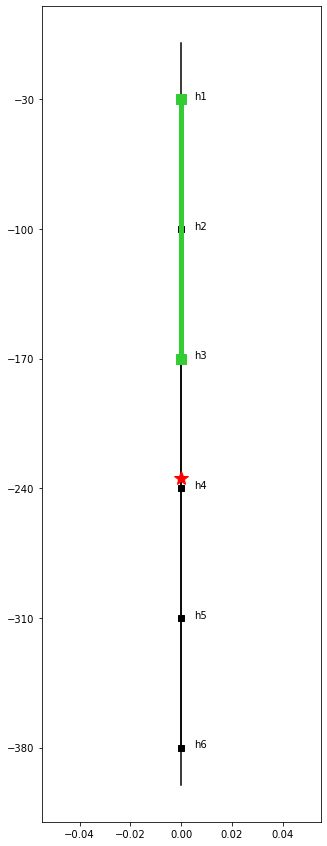

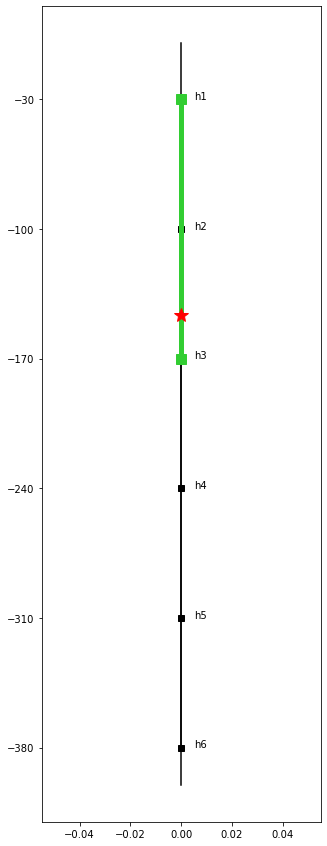

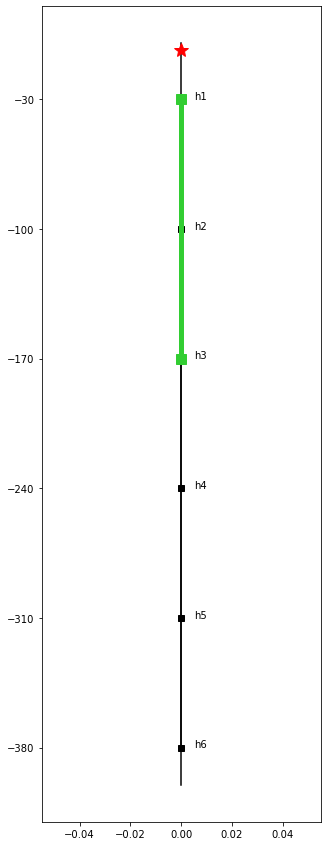

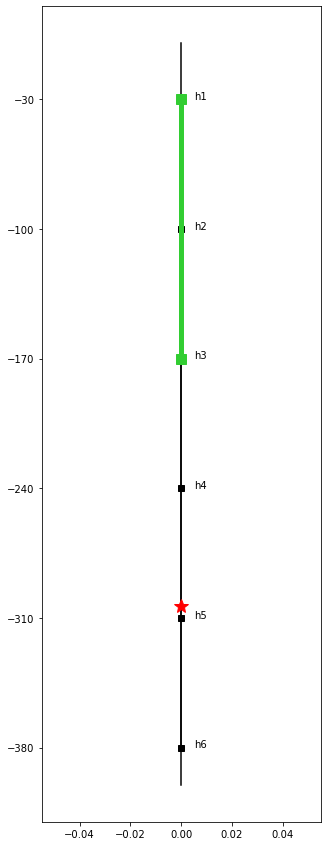

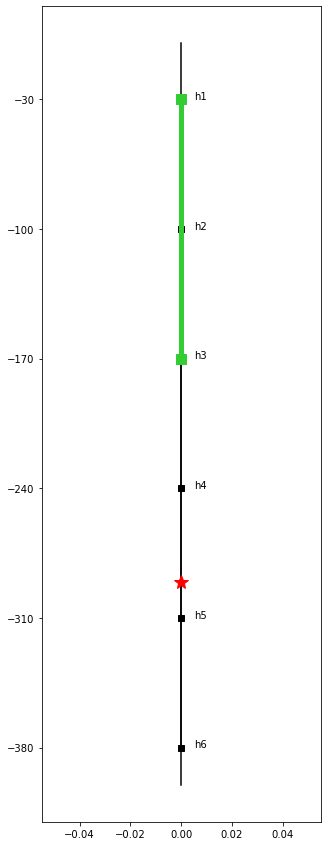

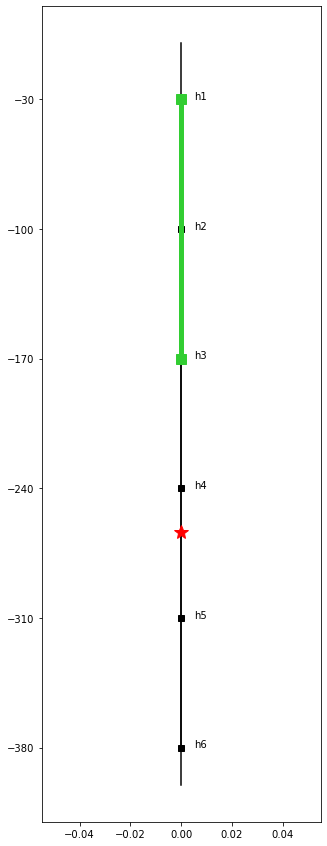

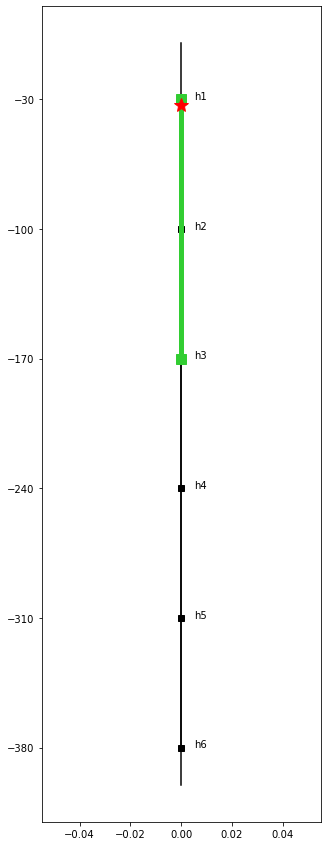

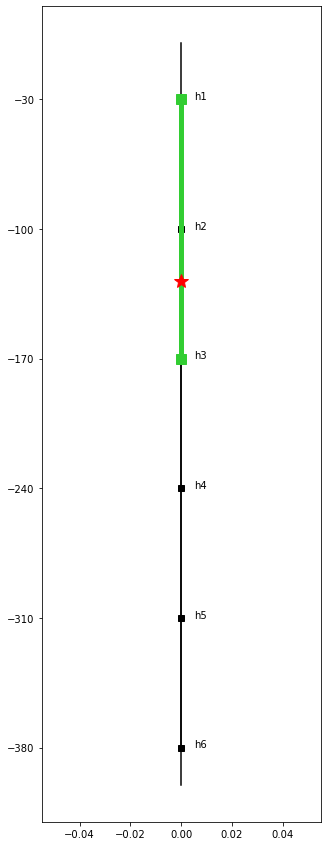

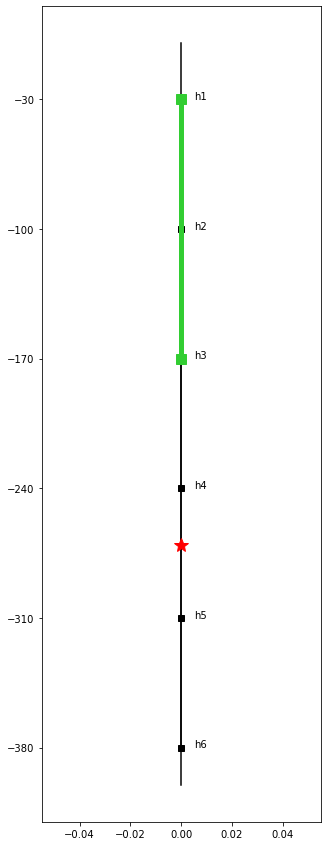

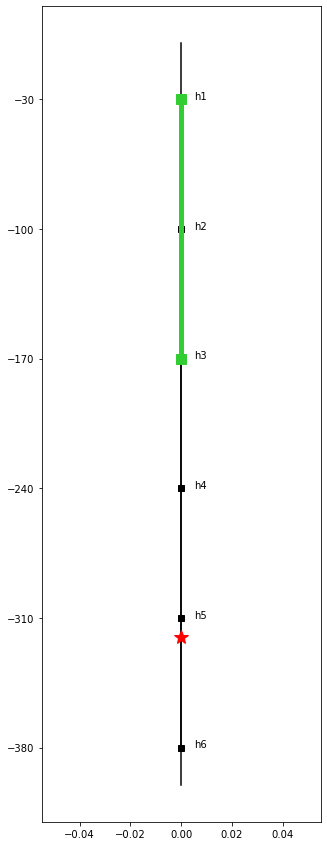

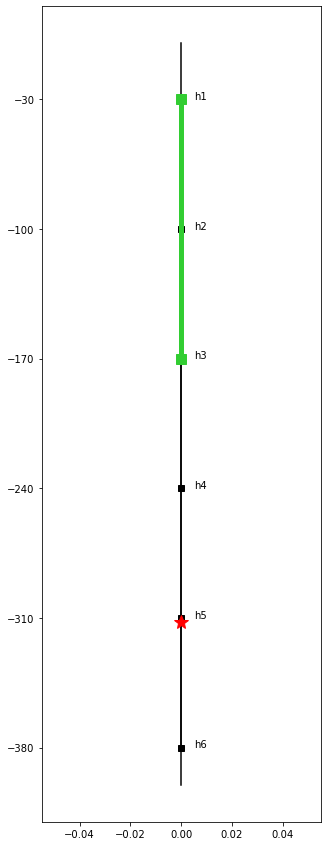

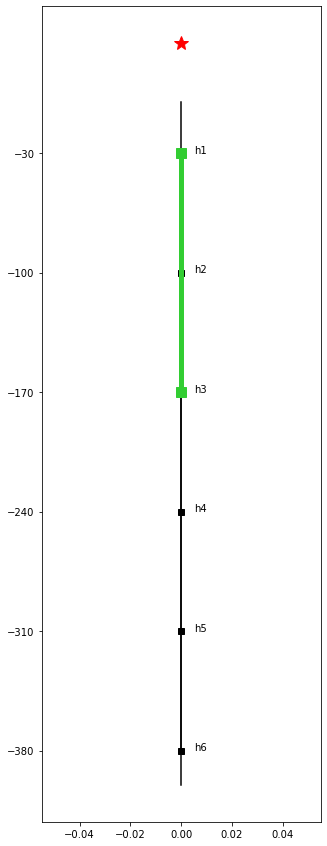

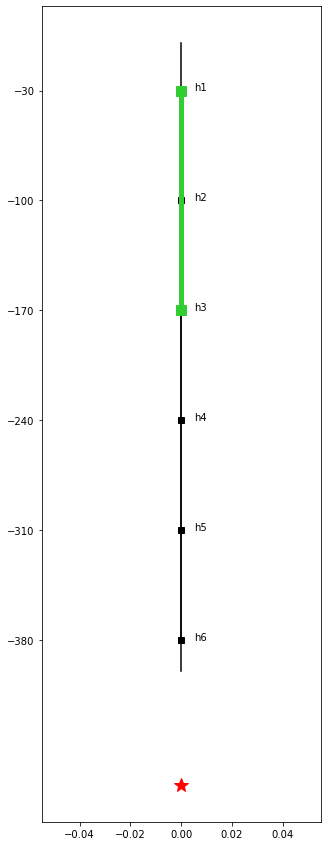

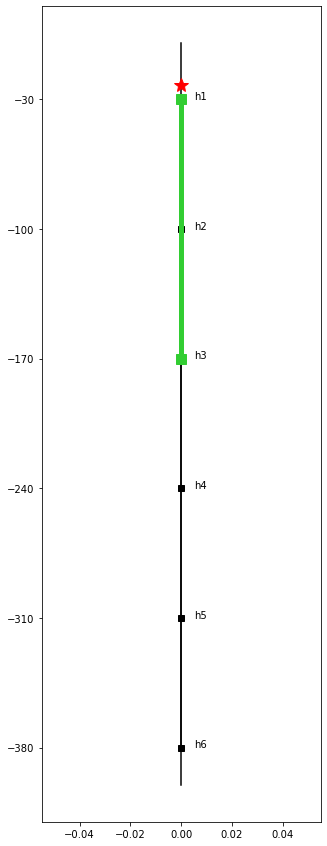

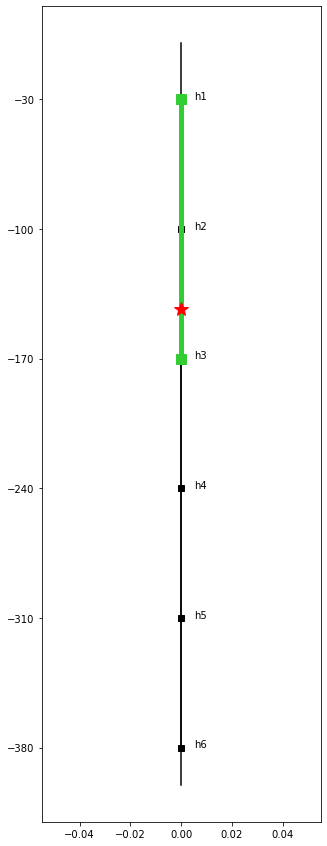

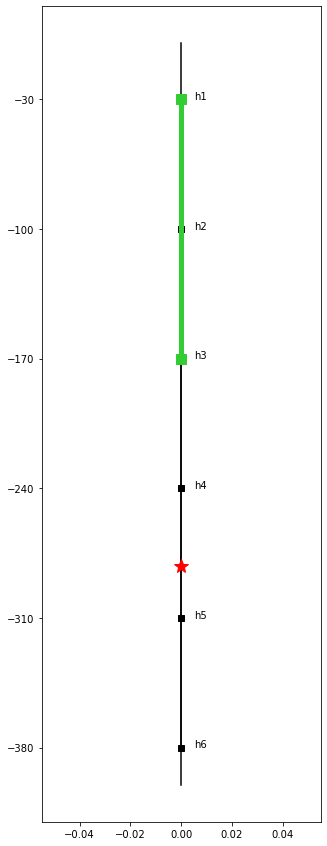

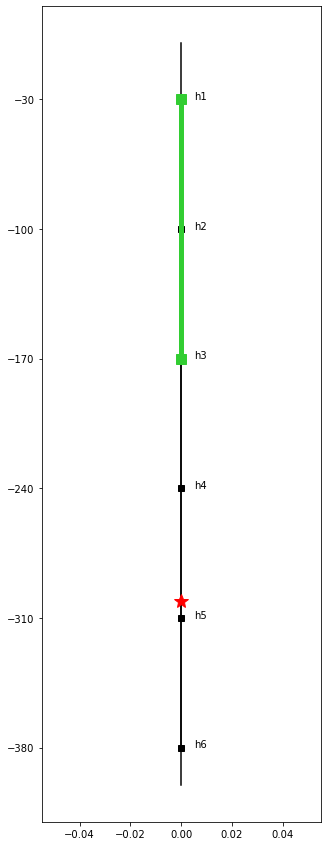

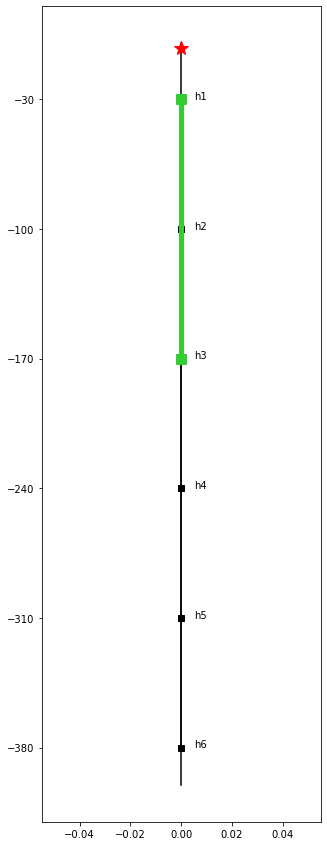

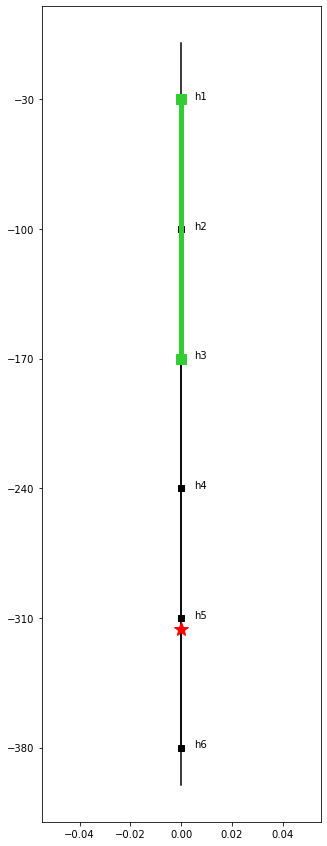

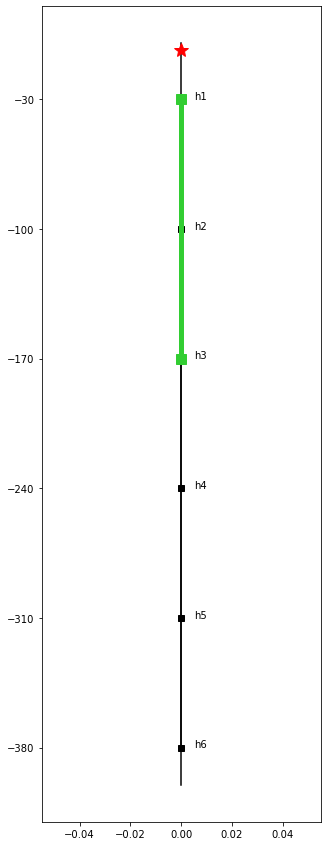

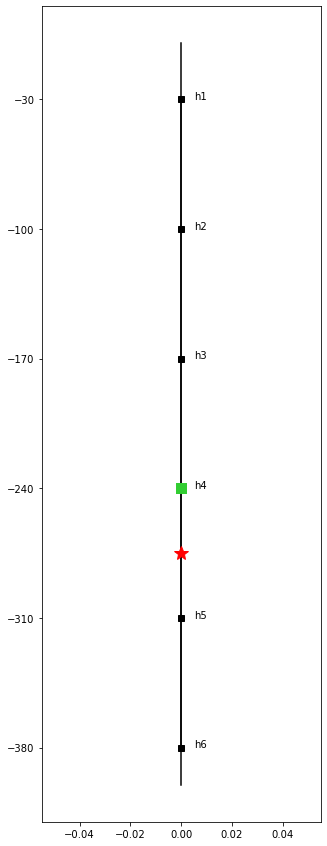

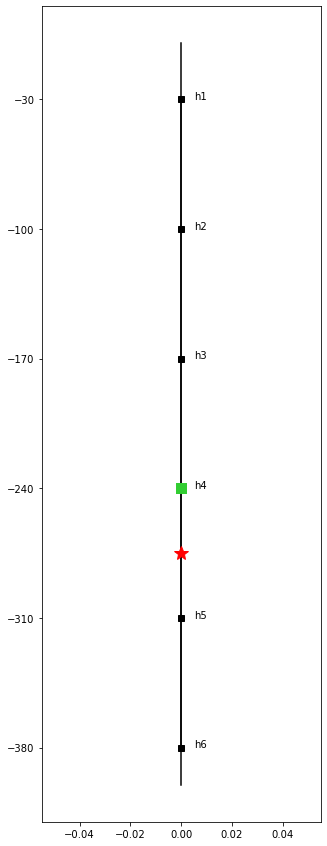

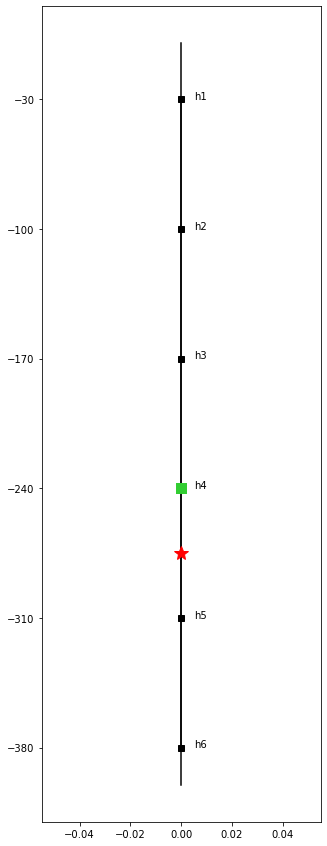

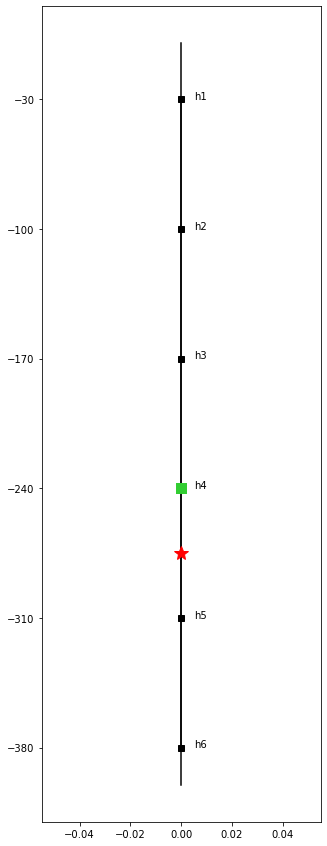

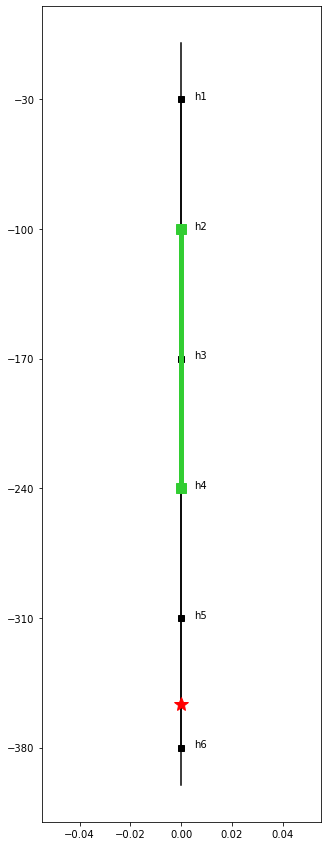

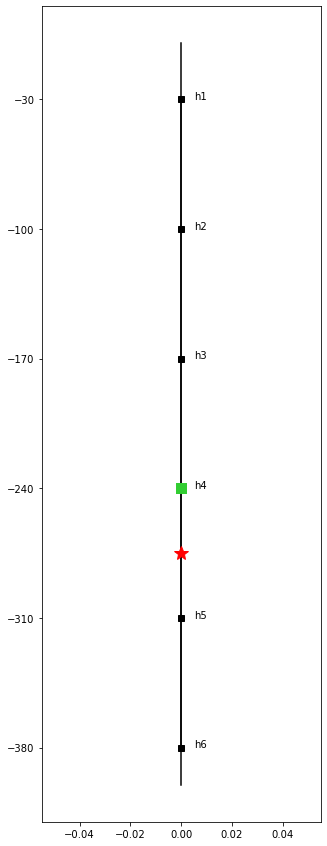

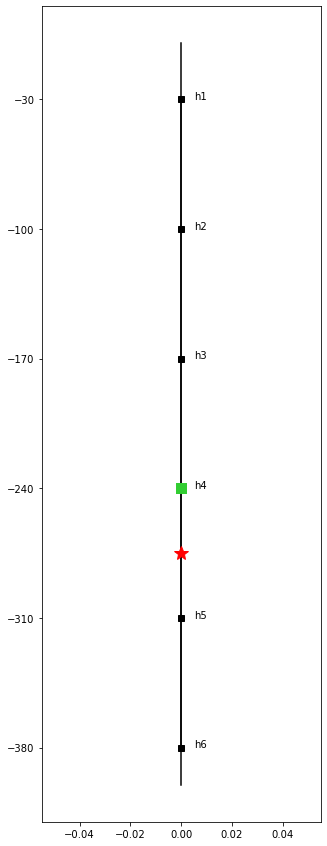

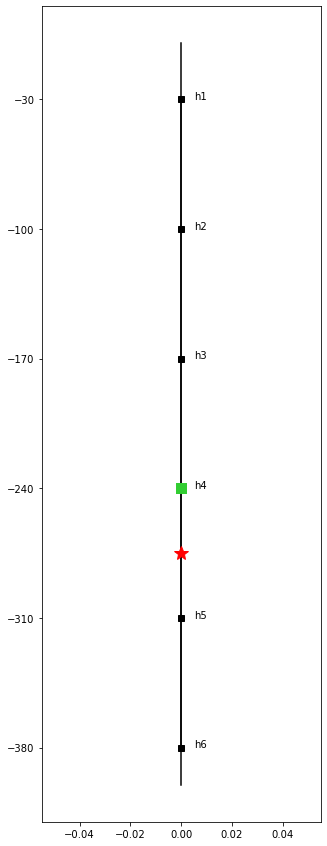

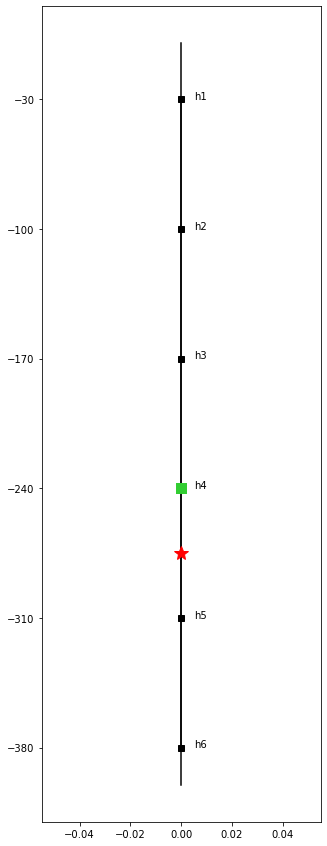

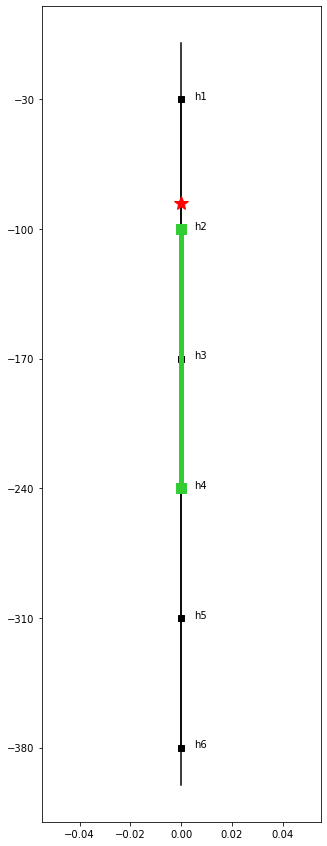

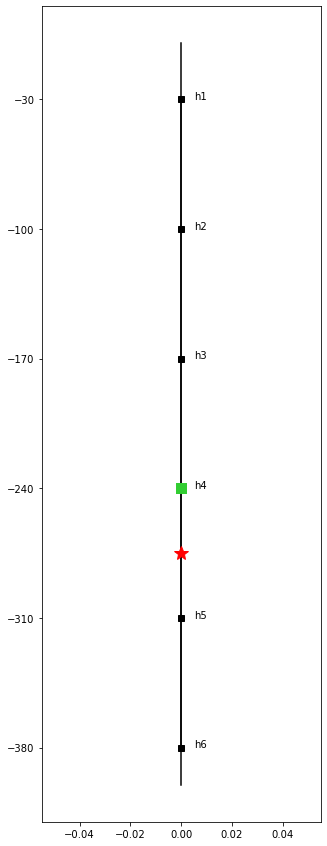

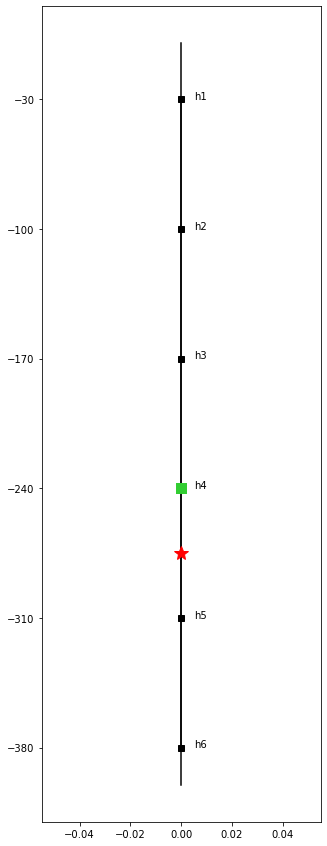

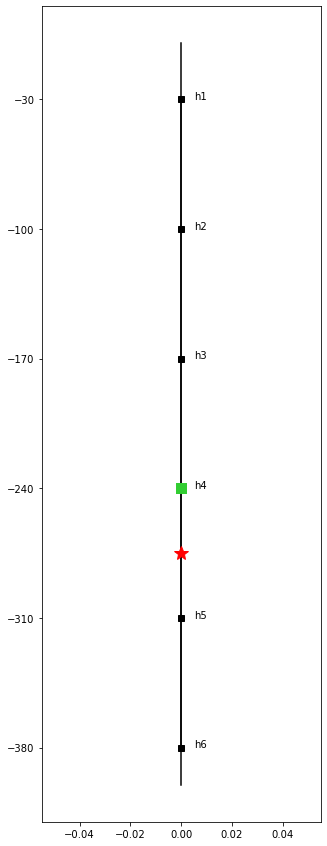

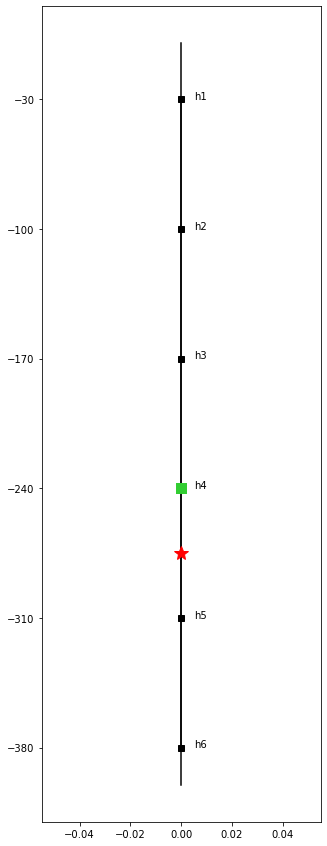

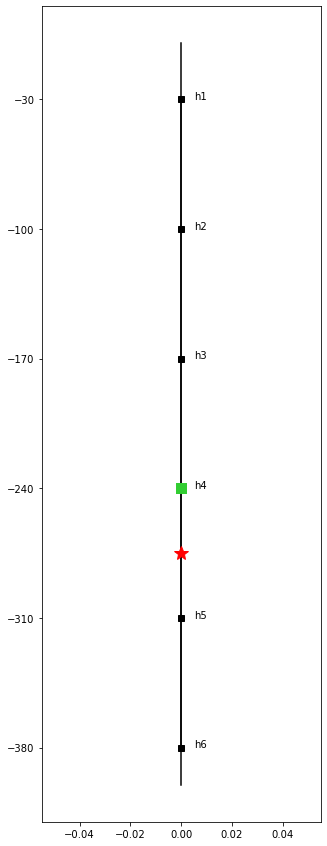

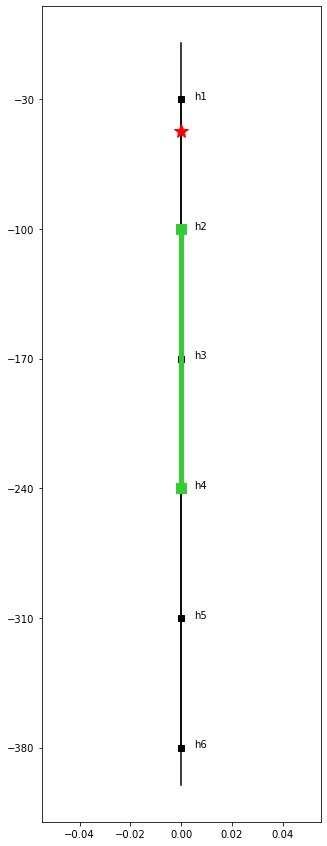

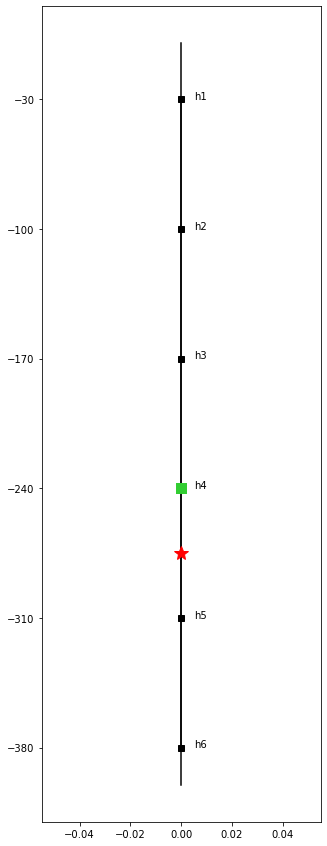

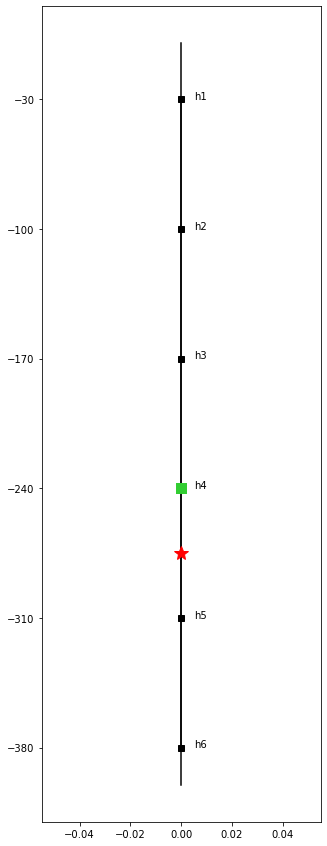

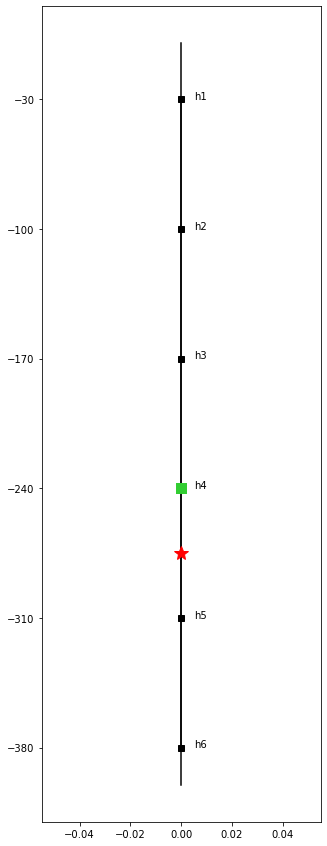

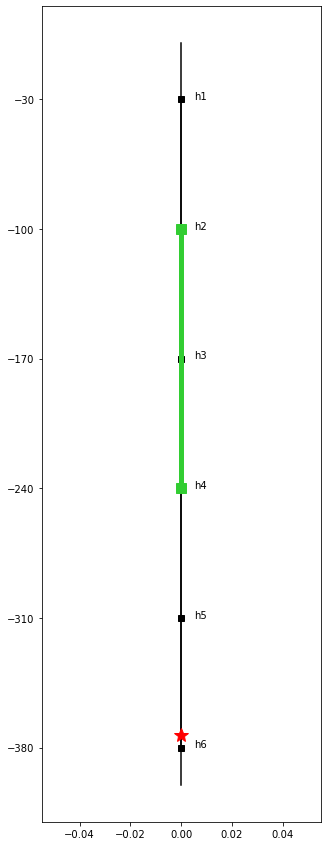

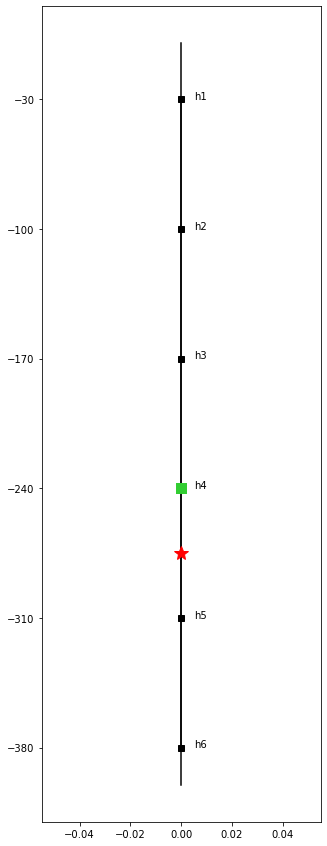

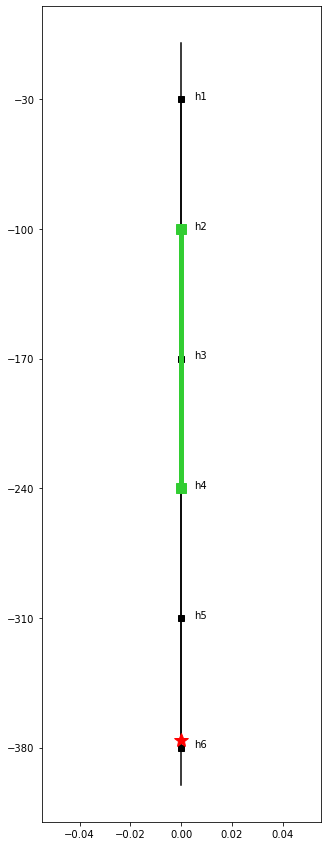

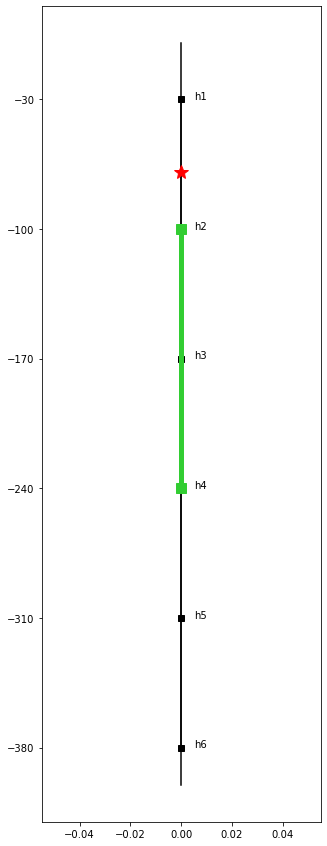

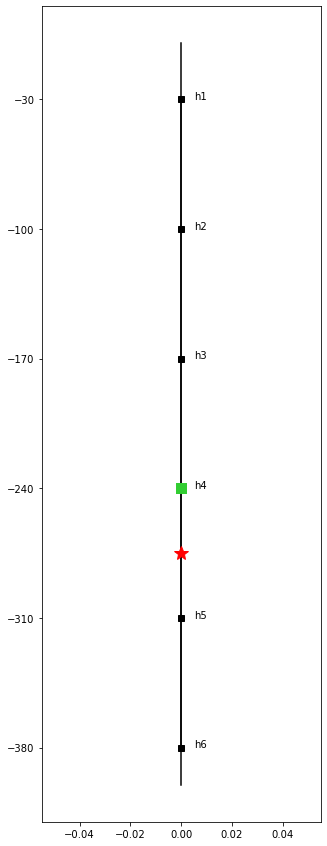

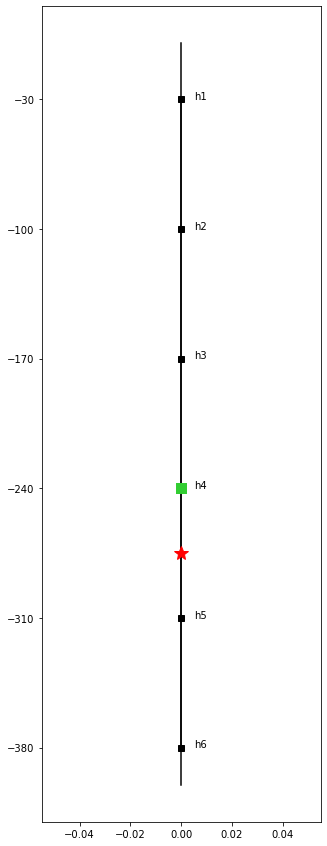

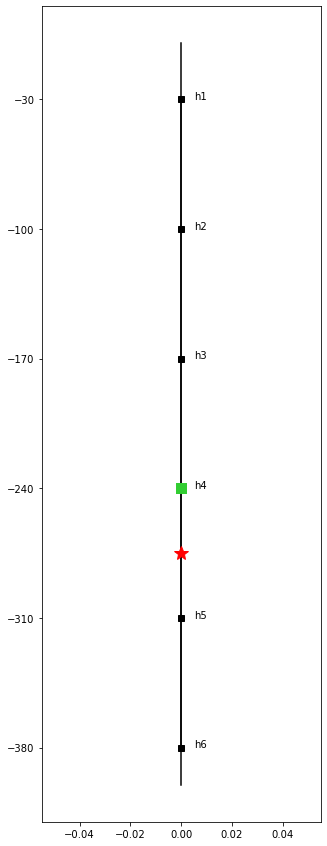

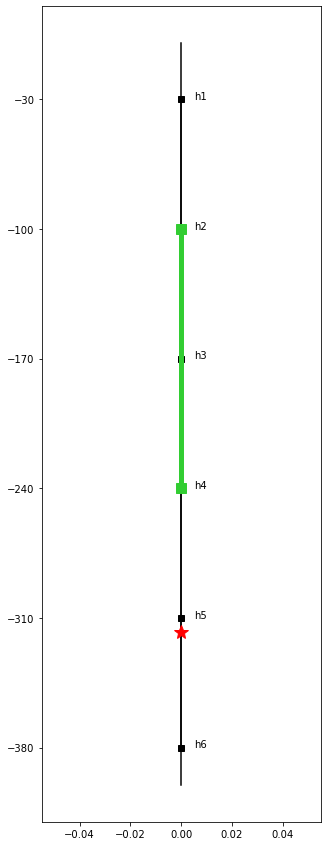

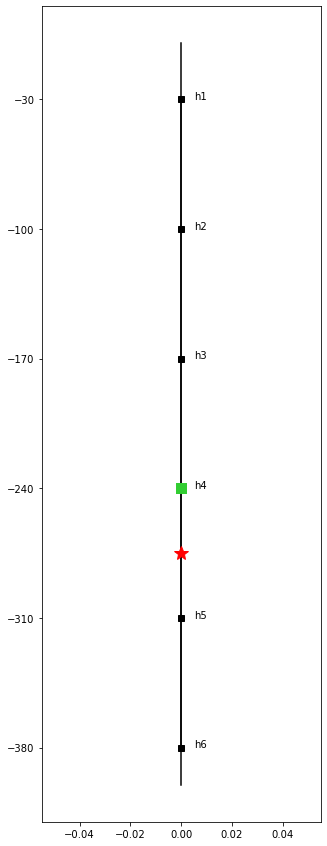

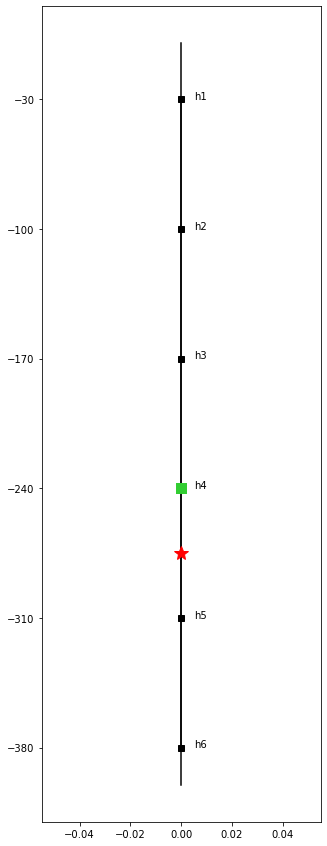

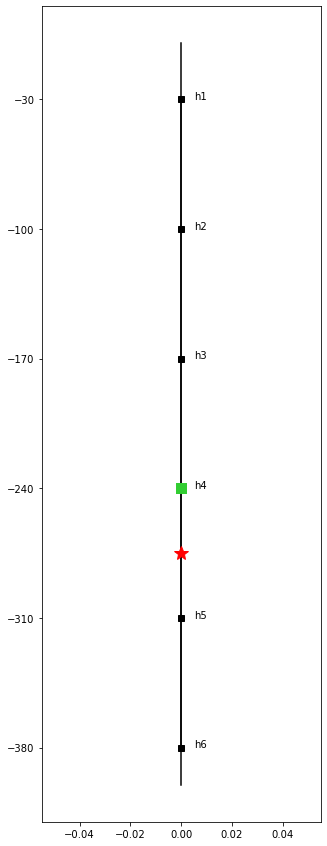

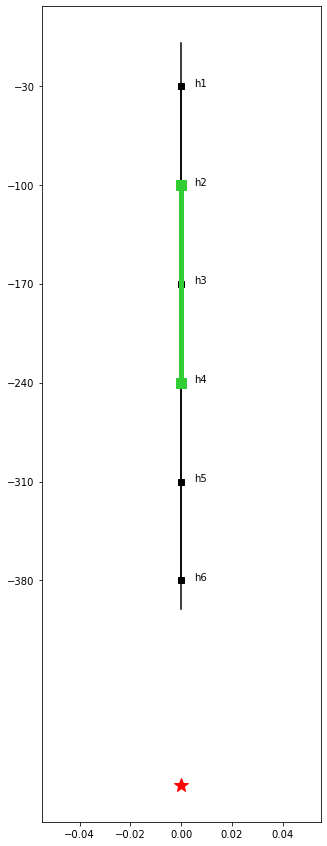

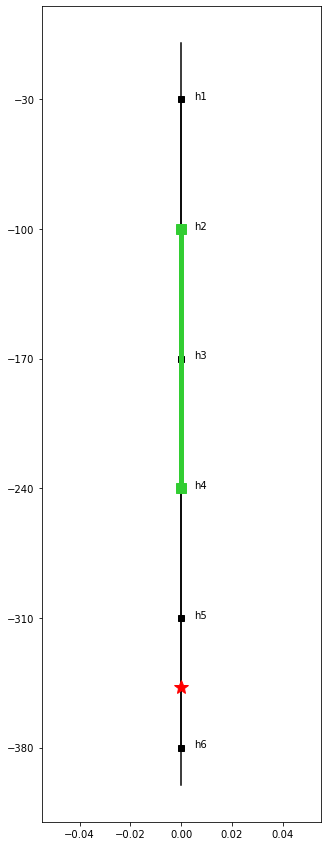

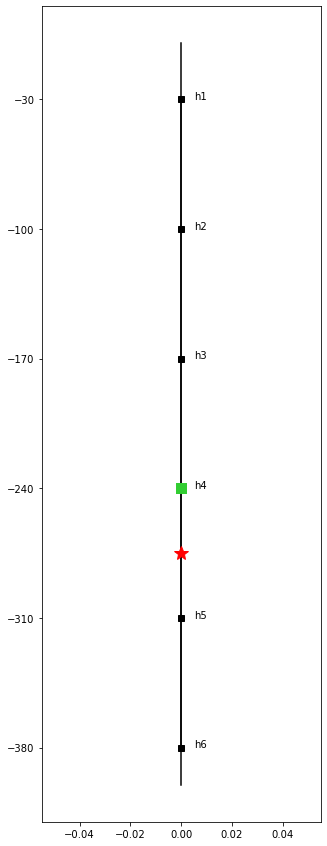

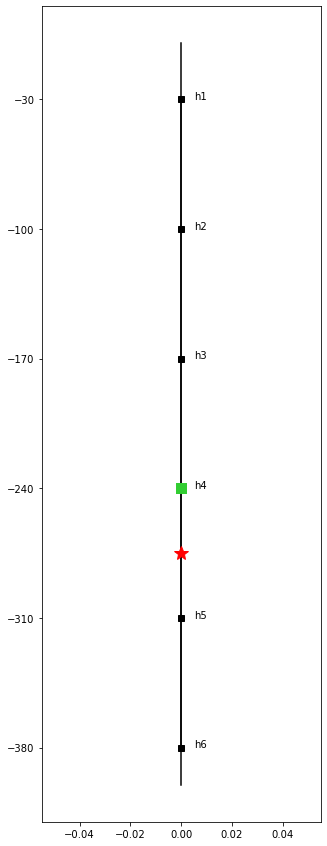

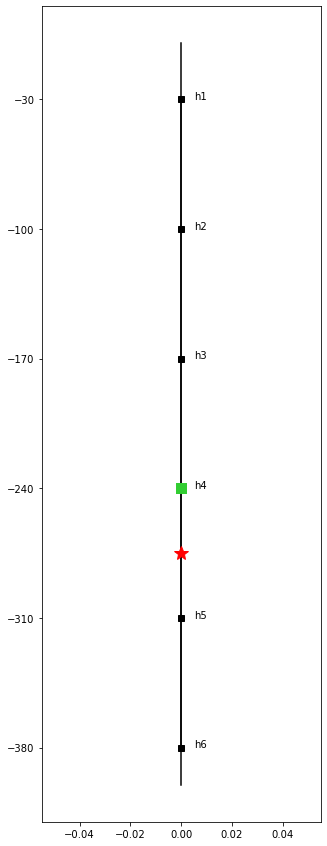

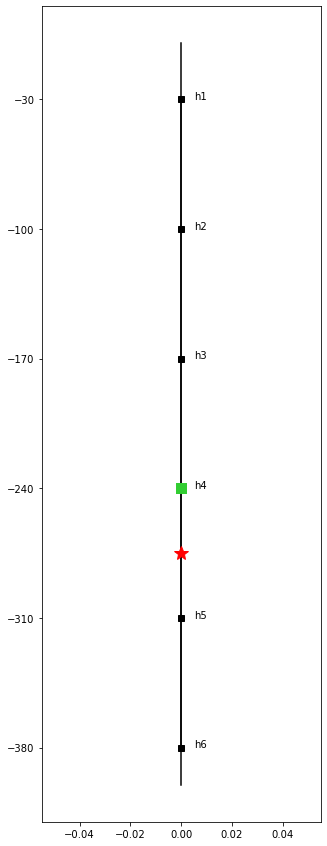

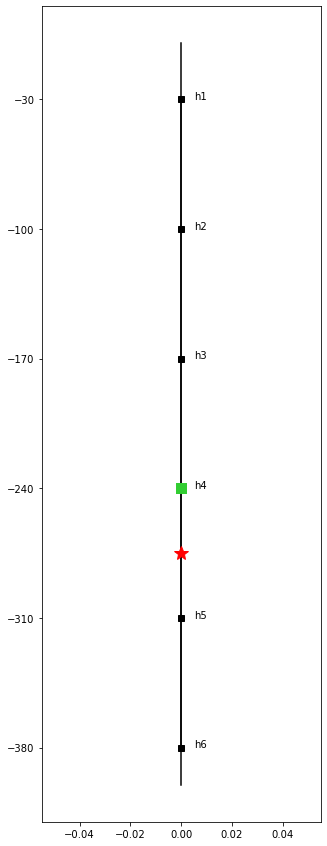

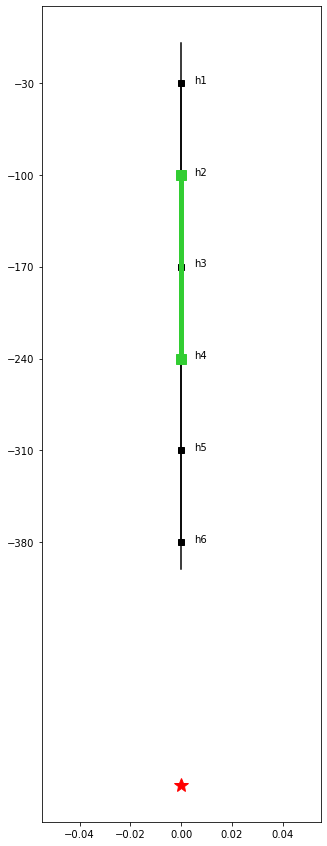

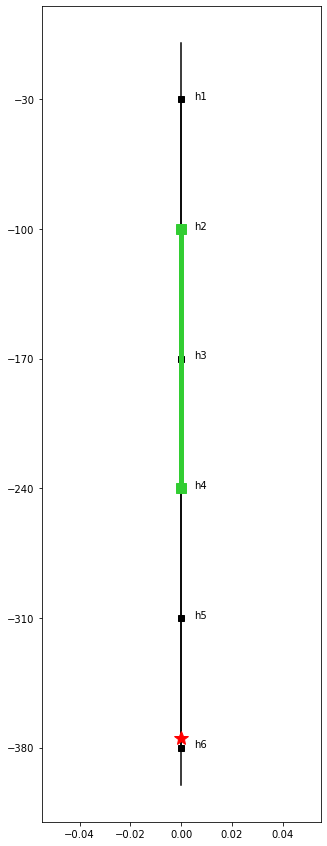

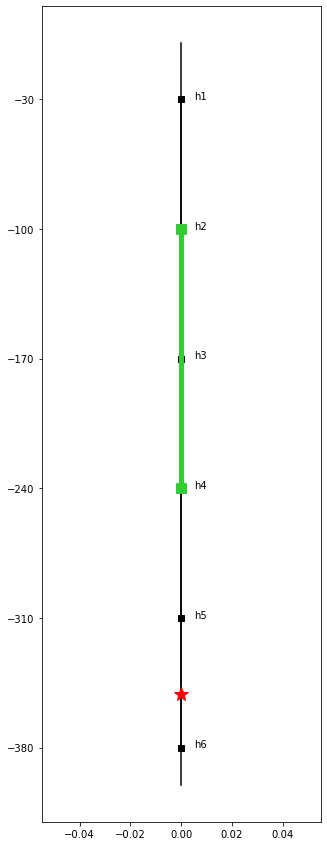

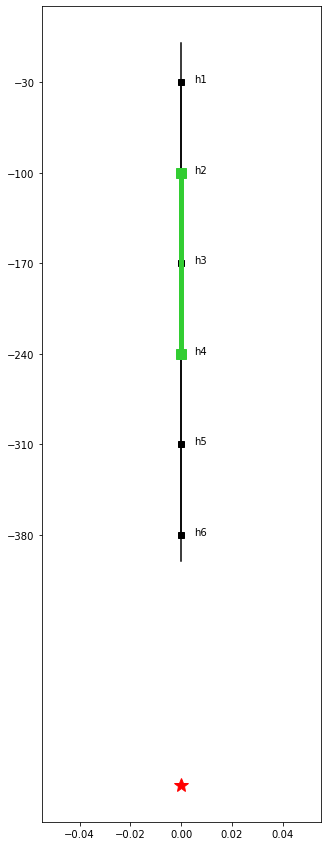

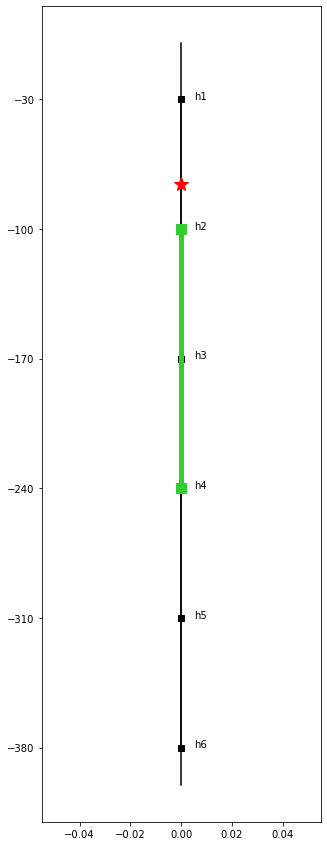

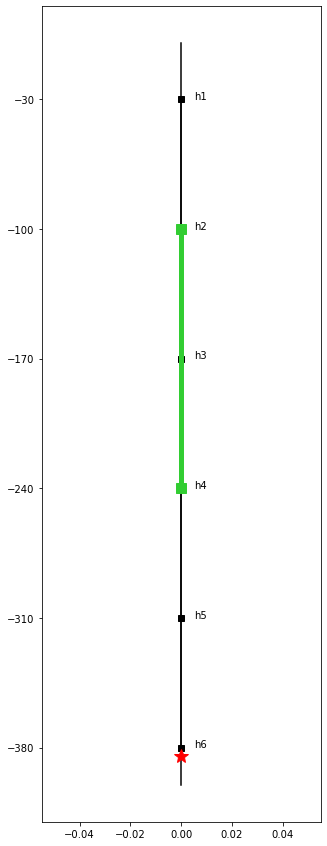

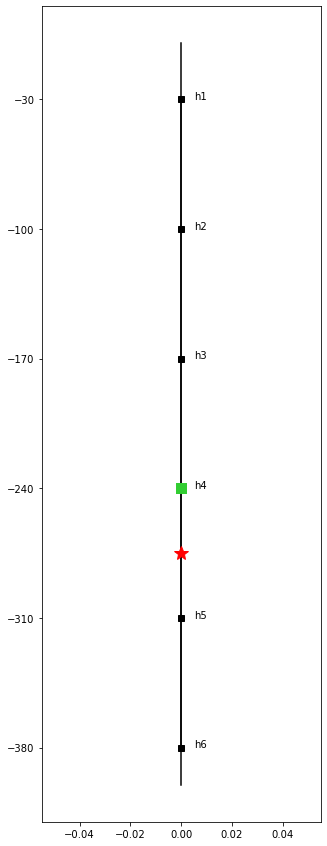

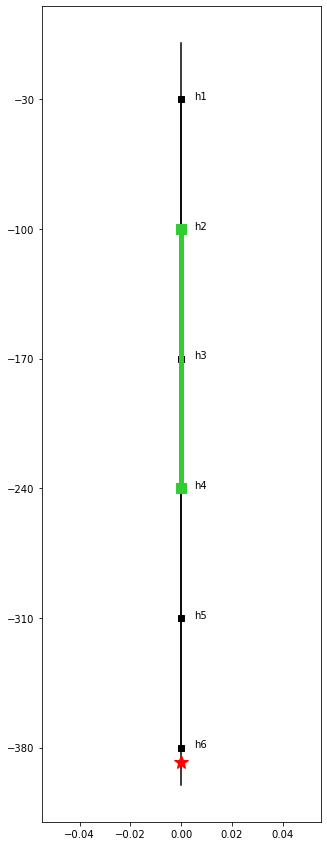

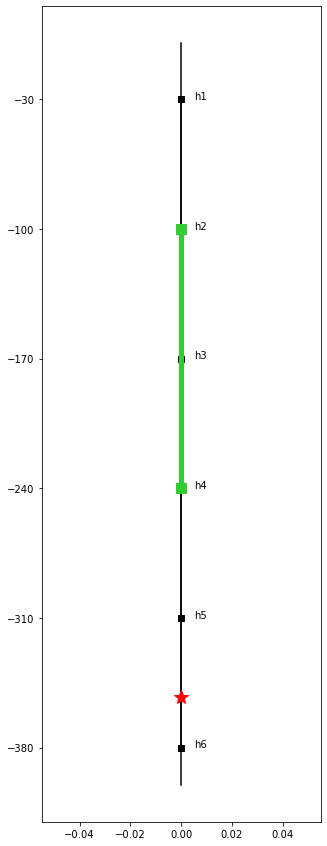

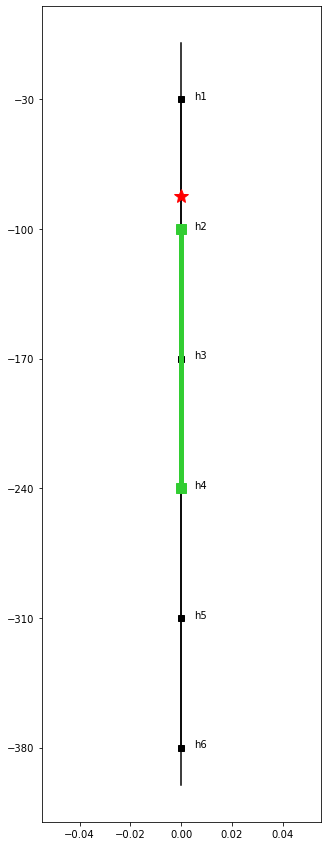

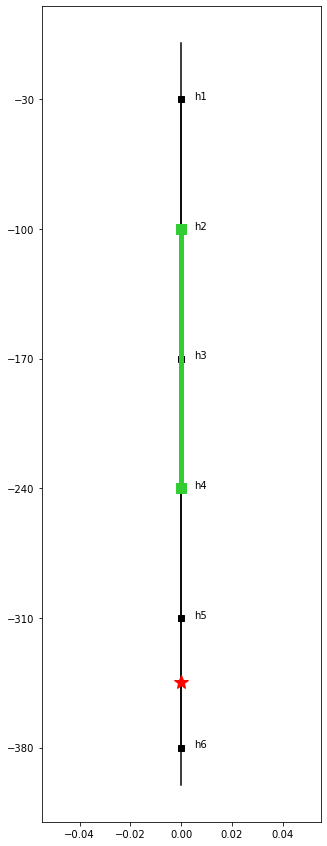

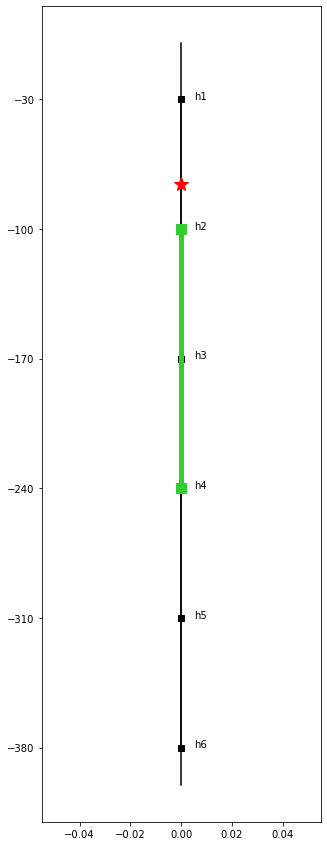

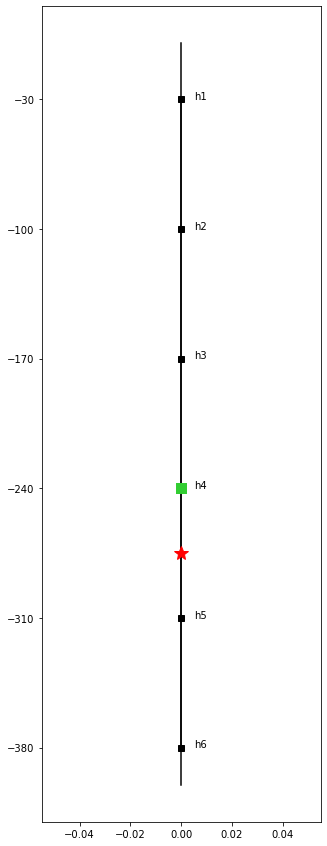

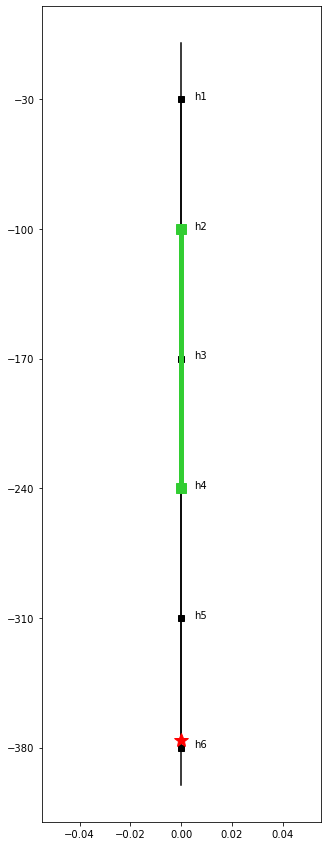

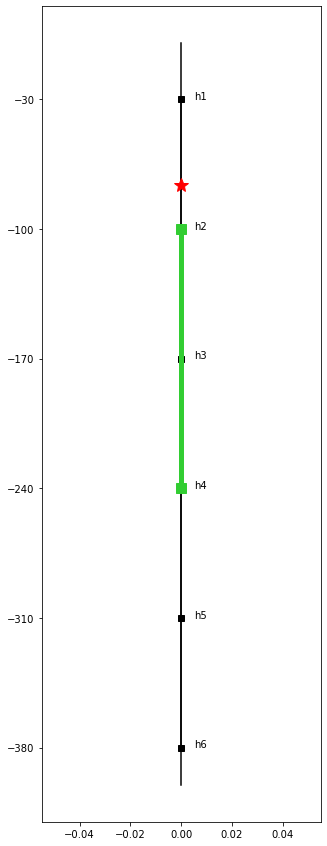

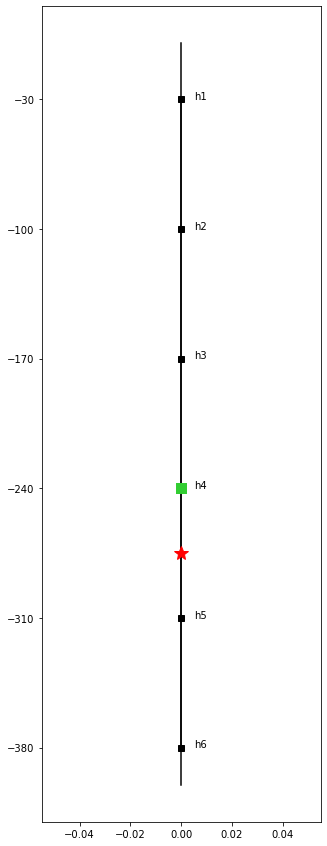

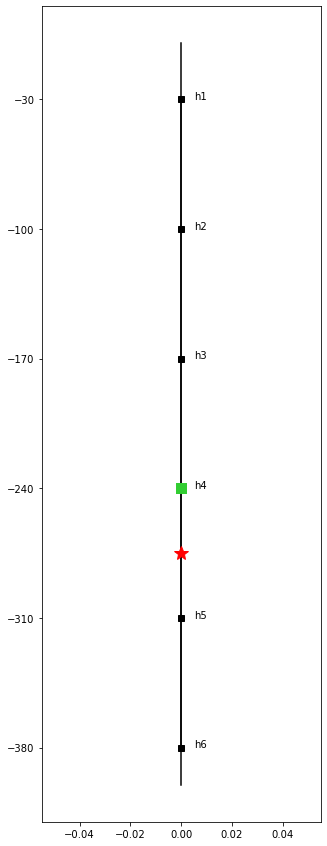

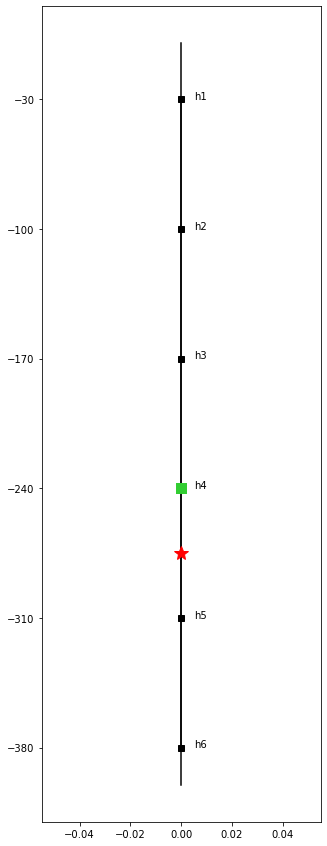

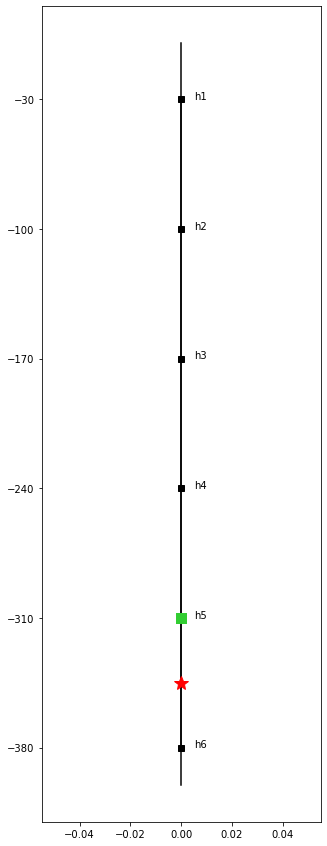

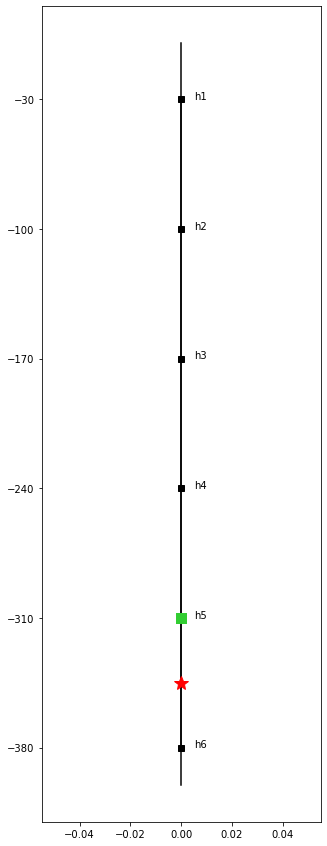

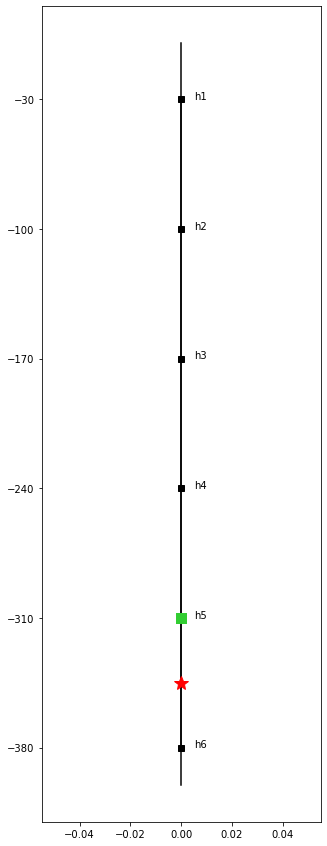

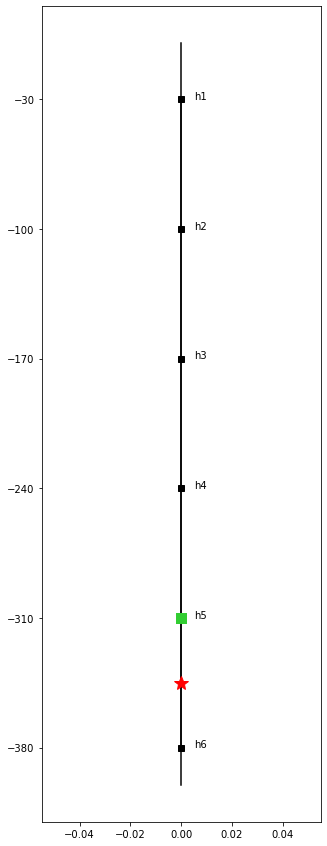

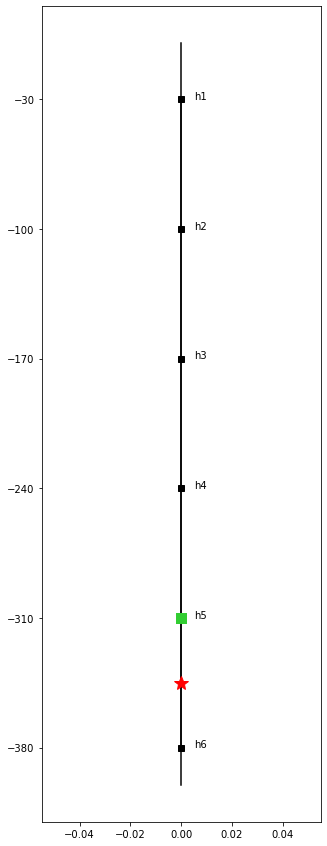

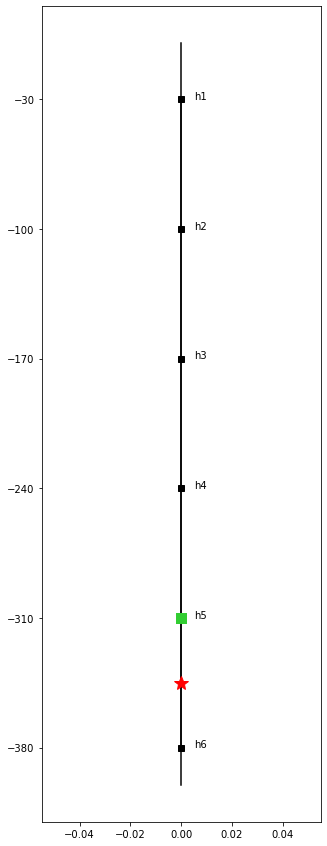

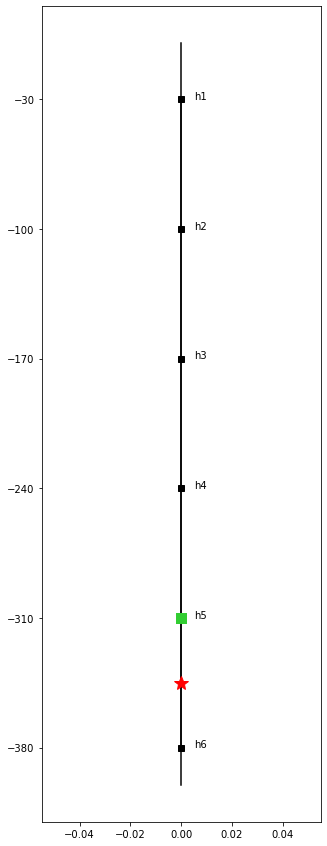

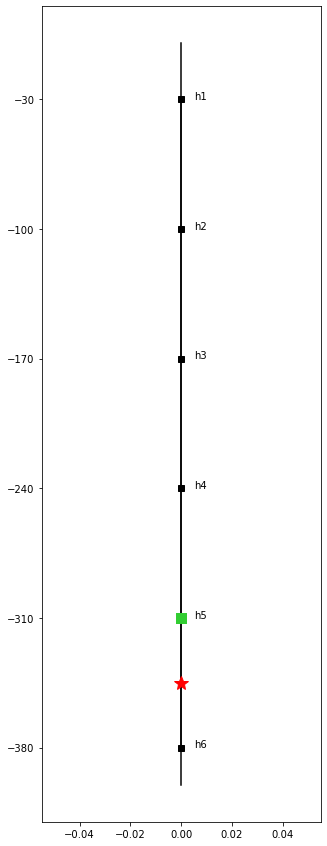

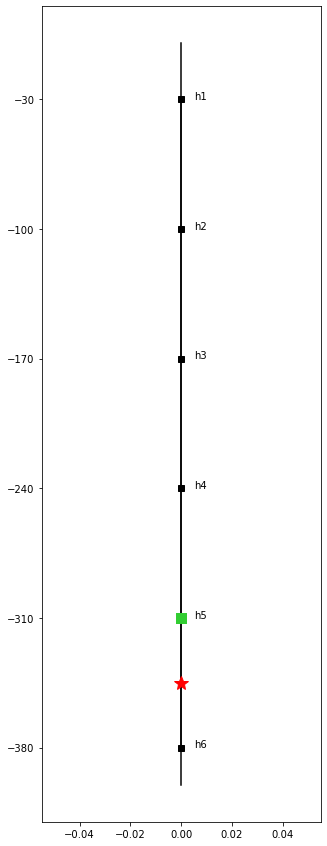

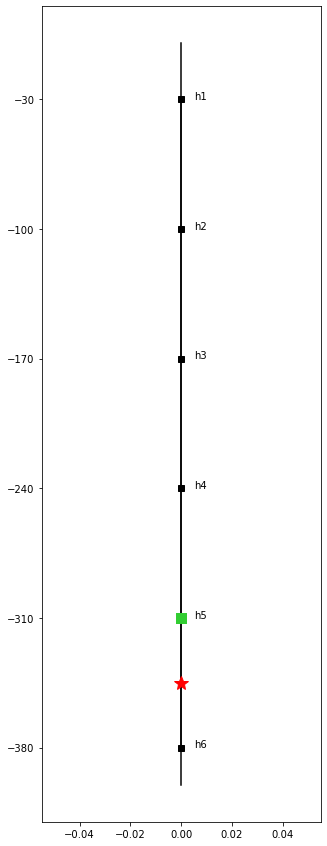

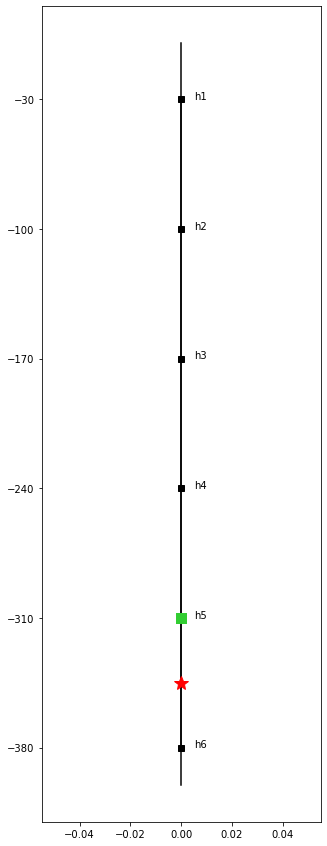

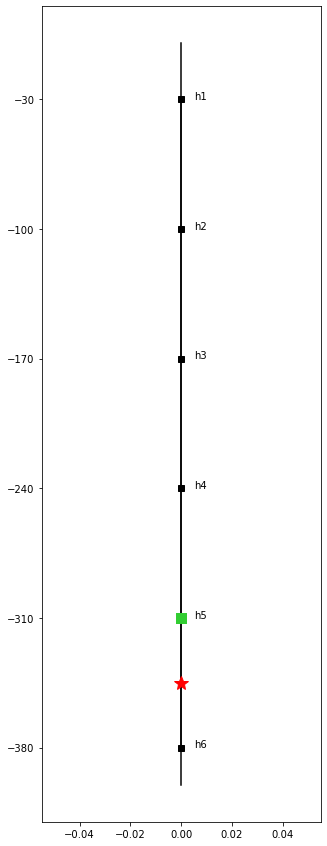

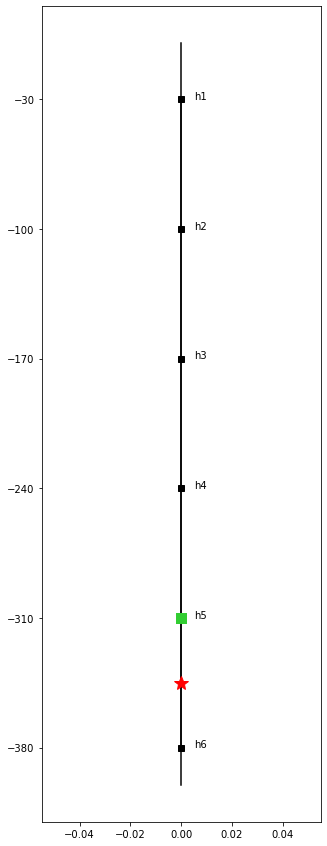

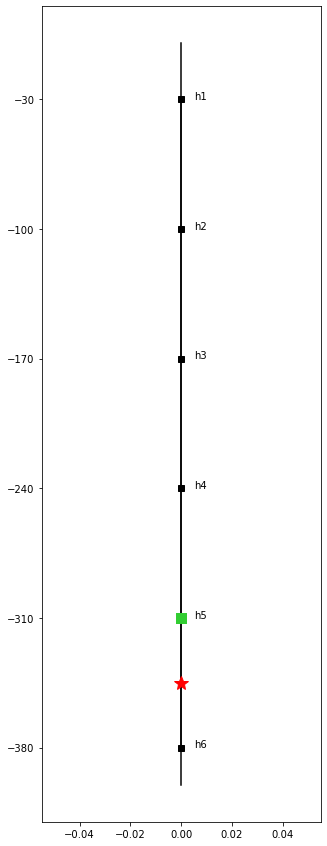

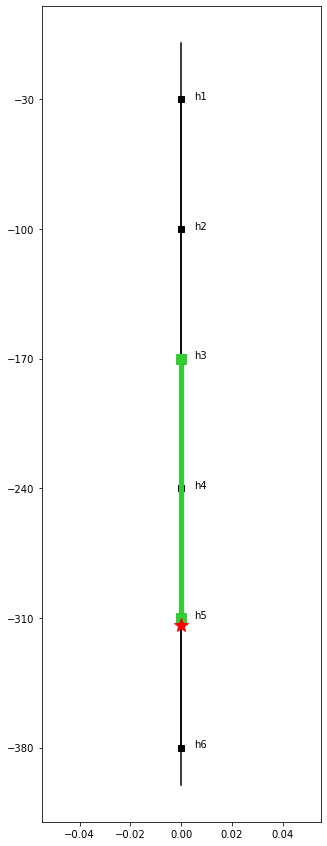

In [93]:
for i in np.arange(100, 1000, 10):
    e = event(id=i)
    fig, ax = e.plot('event depth')
    fig.savefig('figures/event{i}.pdf'.format(i=str(i)), bbox_inches='tight')
# fig, axes = e.plot('waveforms')
# print(e.mpl_times[0].shape)
# for ax, t, cft in zip(axes, e.mpl_times, e.lta_sta_pick()):
#     ax2 = ax.twinx()
#     ax2.plot(t, cft, color='green')

# for ax, t in zip(axes, e.maxamp_pick()):
#     ax.plot((t, t), (-2000, 2000), color='gold')


In [ ]:
iet.df.shape

In [ ]:
# e = event(id=1974)
# # e._get_second_arrival_hydrophone()
# print('first:', e.first_hydrophone_id)
# print('second:', e.second_hydrophone_id)
# e.plot()

In [41]:
hydrophones[e.first_hydrophone_id]

{'depth': 240, 'idx': 3}

In [68]:
# get the arrival hydrophone list index
first_idx = hydrophones[e.first_hydrophone_id]['idx']

# get index for hydrophone above arrival hydrophone
second_idx_above = first_idx - 1

# get index for hydrophone below arrival hydrophone
second_idx_below = first_idx + 1

# take difference in time between hydrophone above and below
above_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_above])).total_seconds()
below_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_below])).total_seconds()

# the minimum time distance is the closer one and therefore the next arrival
argmin = np.argmin([above_tdelta, below_tdelta])

if argmin == 0:
    print(second_idx_above, 'is next')
elif argmin == 1:
    print(second_idx_below, 'is next')
else:
    raise ValueError(argmin, 'should be 0 or 1')

4 is next


In [46]:
# e.aic_t

[18037.337163391207,
 18037.337163506945,
 18037.337163981483,
 18037.3371653125,
 18037.337165520836,
 18037.337166064815]

In [121]:
# e = event(id=750)
# t_A = num2date(e.aic_t[3])
# t_B = num2date(e.aic_t[4])
# dt = (t_A - t_B).total_seconds()
# v_TAB = 1600
# dz_A = 35 + (1/2) * v_TAB * dt
# dz_B = 70 - dz_A
# print('arrival depth A:', dz_A)
# # print('estimated depth (meters):', 170 + dz_A)
# print('estimated depth (meters):', hydrophones[h_id]['depth'] + dz_A) 

arrival depth A: 59.8
estimated depth (meters): 299.8


arrival depth A: 20.6
estimated depth (meters): 260.6


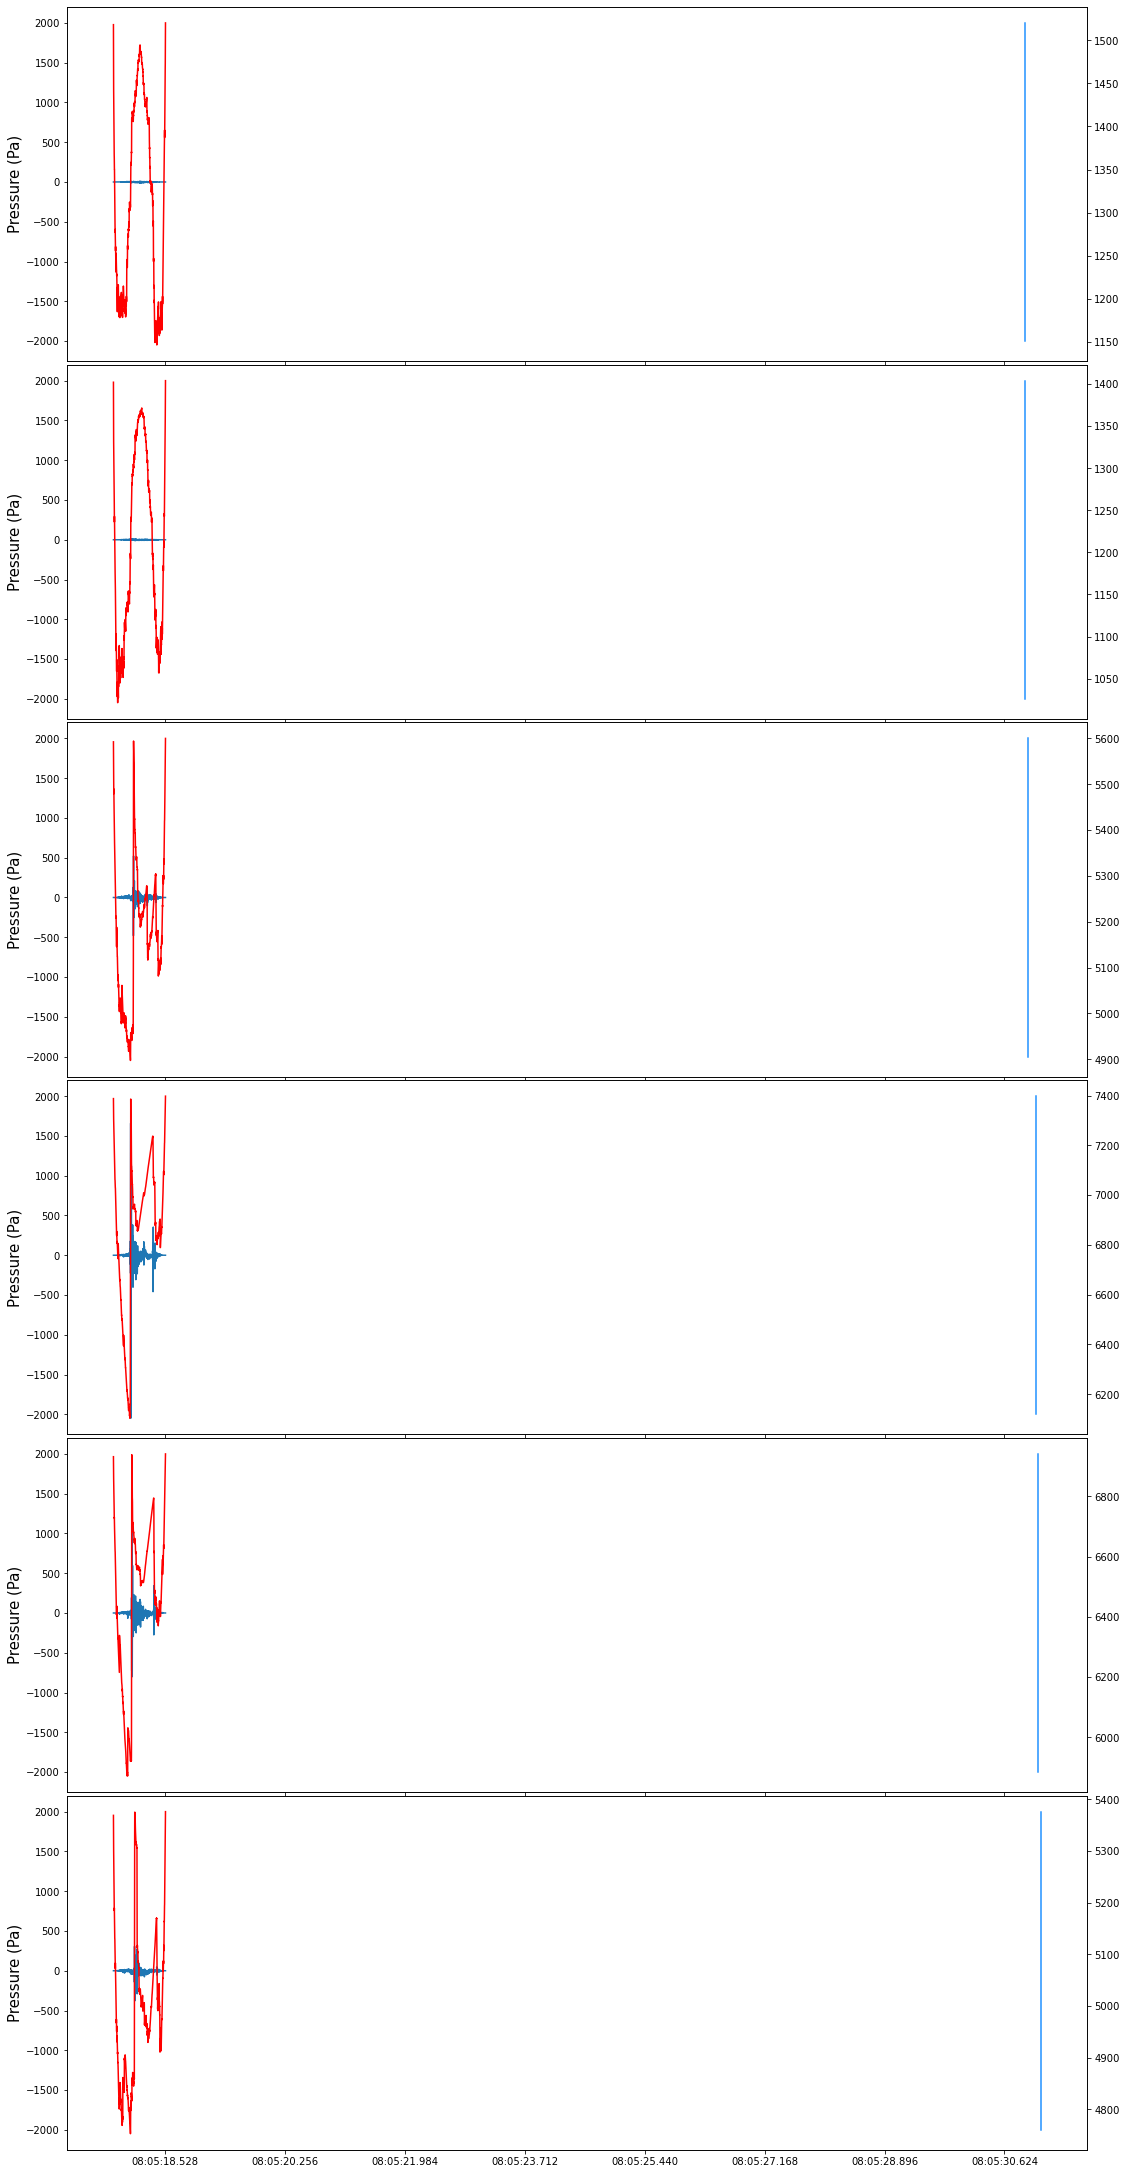

In [122]:
# fig, axes = plotting.plot_waveforms(e.stream)
# for n, ax in enumerate(axes):
#     ax2 = ax.twinx()
#     t = e.stream[n].times('matplotlib')
#     aic = e.aics[n]
#     ax2.plot(t, aic, color='red')
#     ax.plot((aic_t[n], aic_t[n]), (-2000, 2000), color='dodgerblue')
    
# t_A = num2date(aic_t[3])
# t_B = num2date(aic_t[4])
# dt = (t_A - t_B).total_seconds()
# v_TAB = 1600
# dz_A = 35 + (1/2) * v_TAB * dt
# dz_B = 70 - dz_A
# print('arrival depth A:', dz_A)
# # print('estimated depth (meters):', 170 + dz_A)
# print('estimated depth (meters):', hydrophones[h_id]['depth'] + dz_A)    

arrival depth A: 20.6
estimated depth (meters): 260.6
index                                                462
event_times (mpl)                           18037.337165
event_times (abs)            2019-05-21T08:05:31.098000Z
hphone_idx                                            h4
ones                                                   1
event_times             2019-05-21 08:05:31.098000+00:00
p_arrival_hphone_idx    2019-05-21 08:05:31.083000+00:00
Name: 760, dtype: object


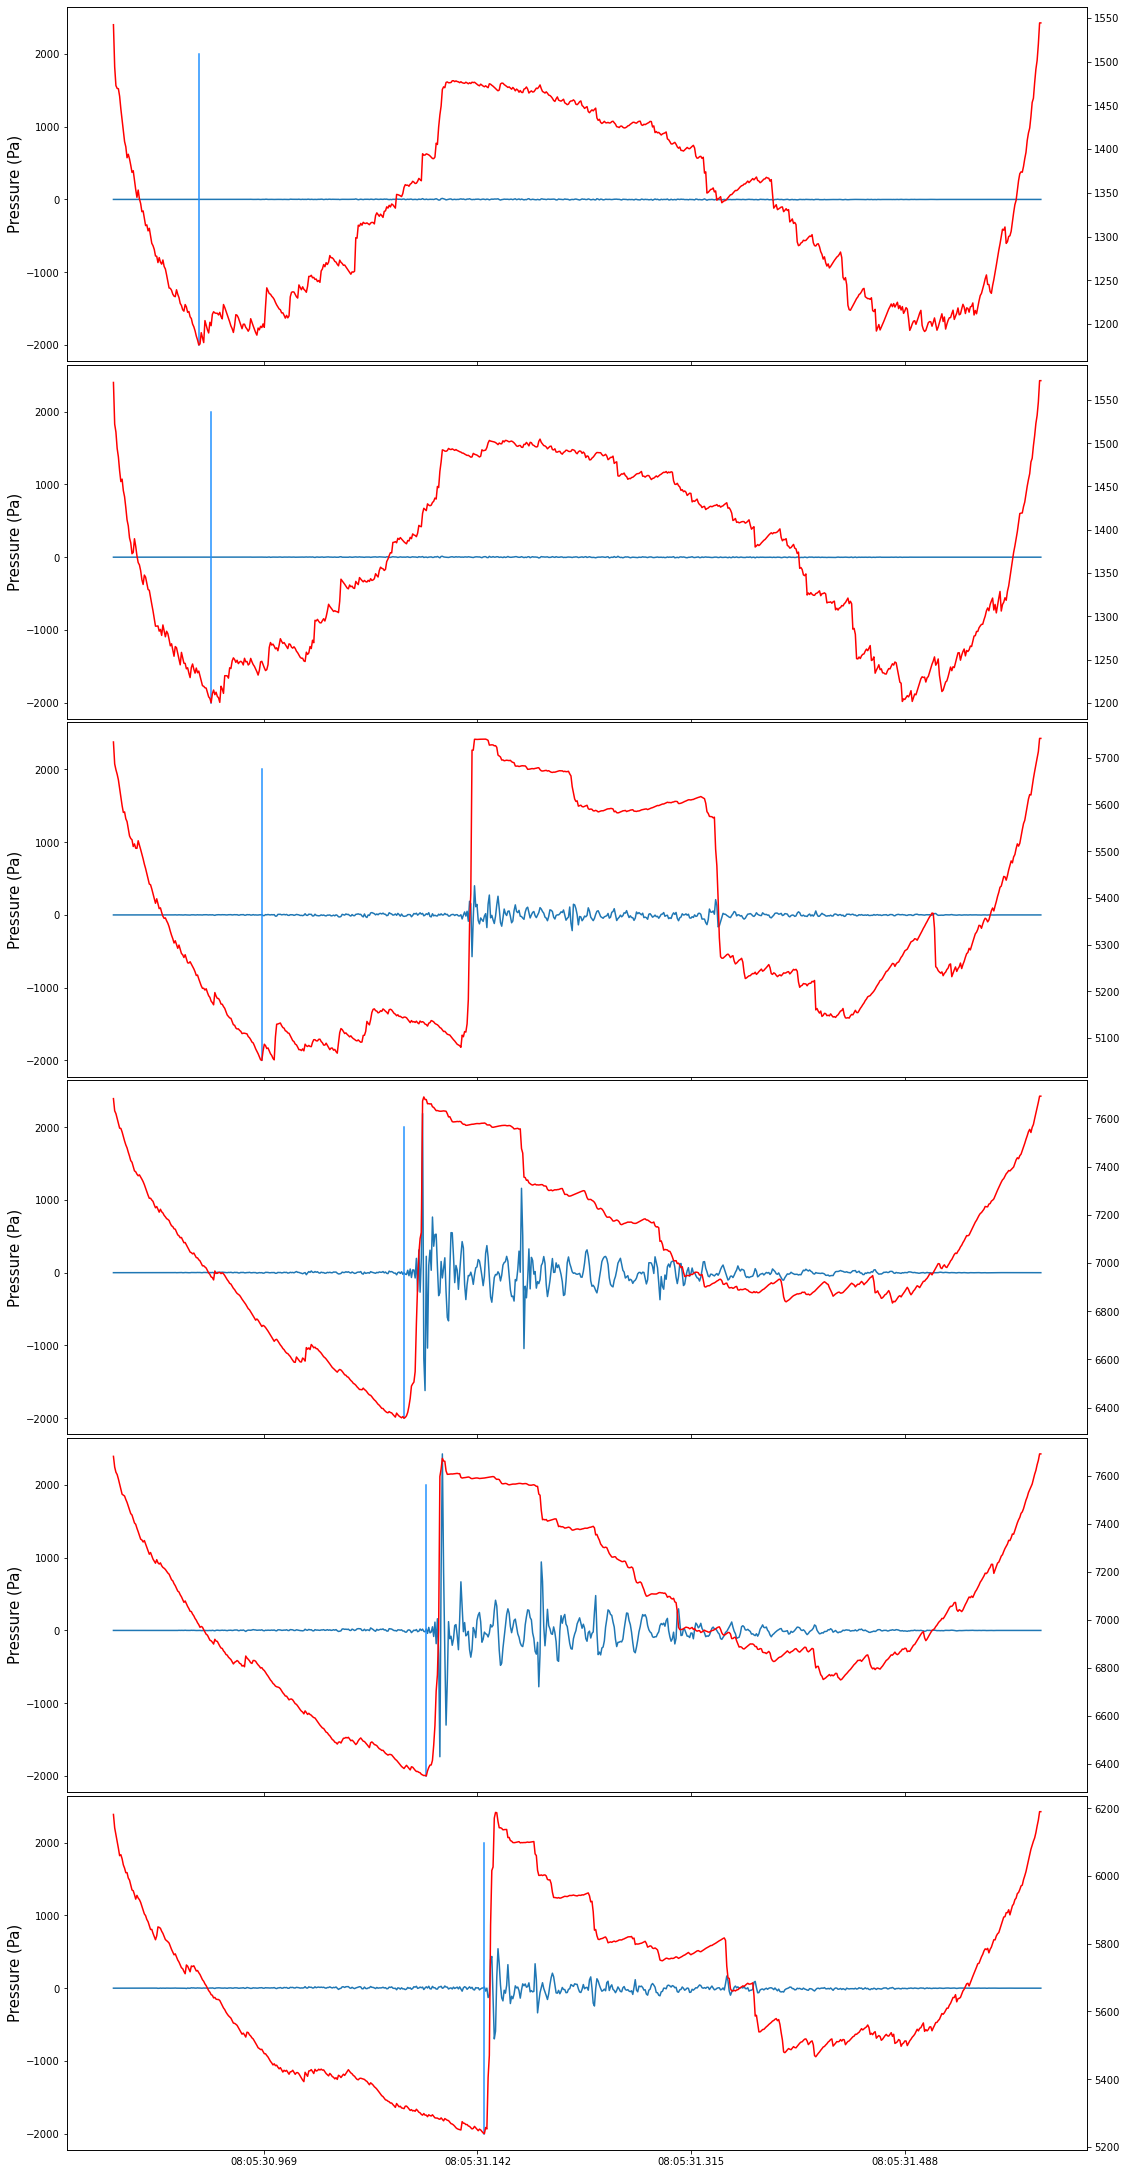

In [2]:
# iet_e = iet.df.iloc[760]
# starttime = iet_e['event_times (abs)']
# h_id = iet_e['hphone_idx']
# e = get_waveforms(starttime=starttime)
# aic_t, aics = aic_pick(e)

# fig, axes = plotting.plot_waveforms(e)
# for n, ax in enumerate(axes):
#     ax2 = ax.twinx()
#     t = e[n].times('matplotlib')
#     aic = aics[n]
#     ax2.plot(t, aic, color='red')
#     ax.plot((aic_t[n], aic_t[n]), (-2000, 2000), color='dodgerblue')

# t_A = num2date(aic_t[3])
# t_B = num2date(aic_t[4])
# dt = (t_A - t_B).total_seconds()
# v_TAB = 1600
# dz_A = 35 + (1/2) * v_TAB * dt
# dz_B = 70 - dz_A
# print('arrival depth A:', dz_A)
# # print('estimated depth (meters):', 170 + dz_A)
# print('estimated depth (meters):', hydrophones[h_id]['depth'] + dz_A)
# print(iet.df.iloc[760])

In [3]:
# [num2date(a) for a in aic_t]

[datetime.datetime(2019, 5, 21, 8, 5, 30, 917000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 30, 927000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 30, 968000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 31, 83000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 31, 101000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 31, 148000, tzinfo=datetime.timezone.utc)]